## Importing libraries and data

### Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as snsa
import matplotlib.pylab as plt
from matplotlib import pyplot
from IPython.display import Image
import datetime
from bs4 import BeautifulSoup
import re
import requests
import pymysql
from sqlalchemy import create_engine
import getpass
import statistics as stat
from scipy.stats import ttest_1samp

### Main dataset

In [2]:
df = pd.read_csv(r'/Users/larag/Documents/Ironhack/final_project/Hotel_Reviews.csv')

### Variables

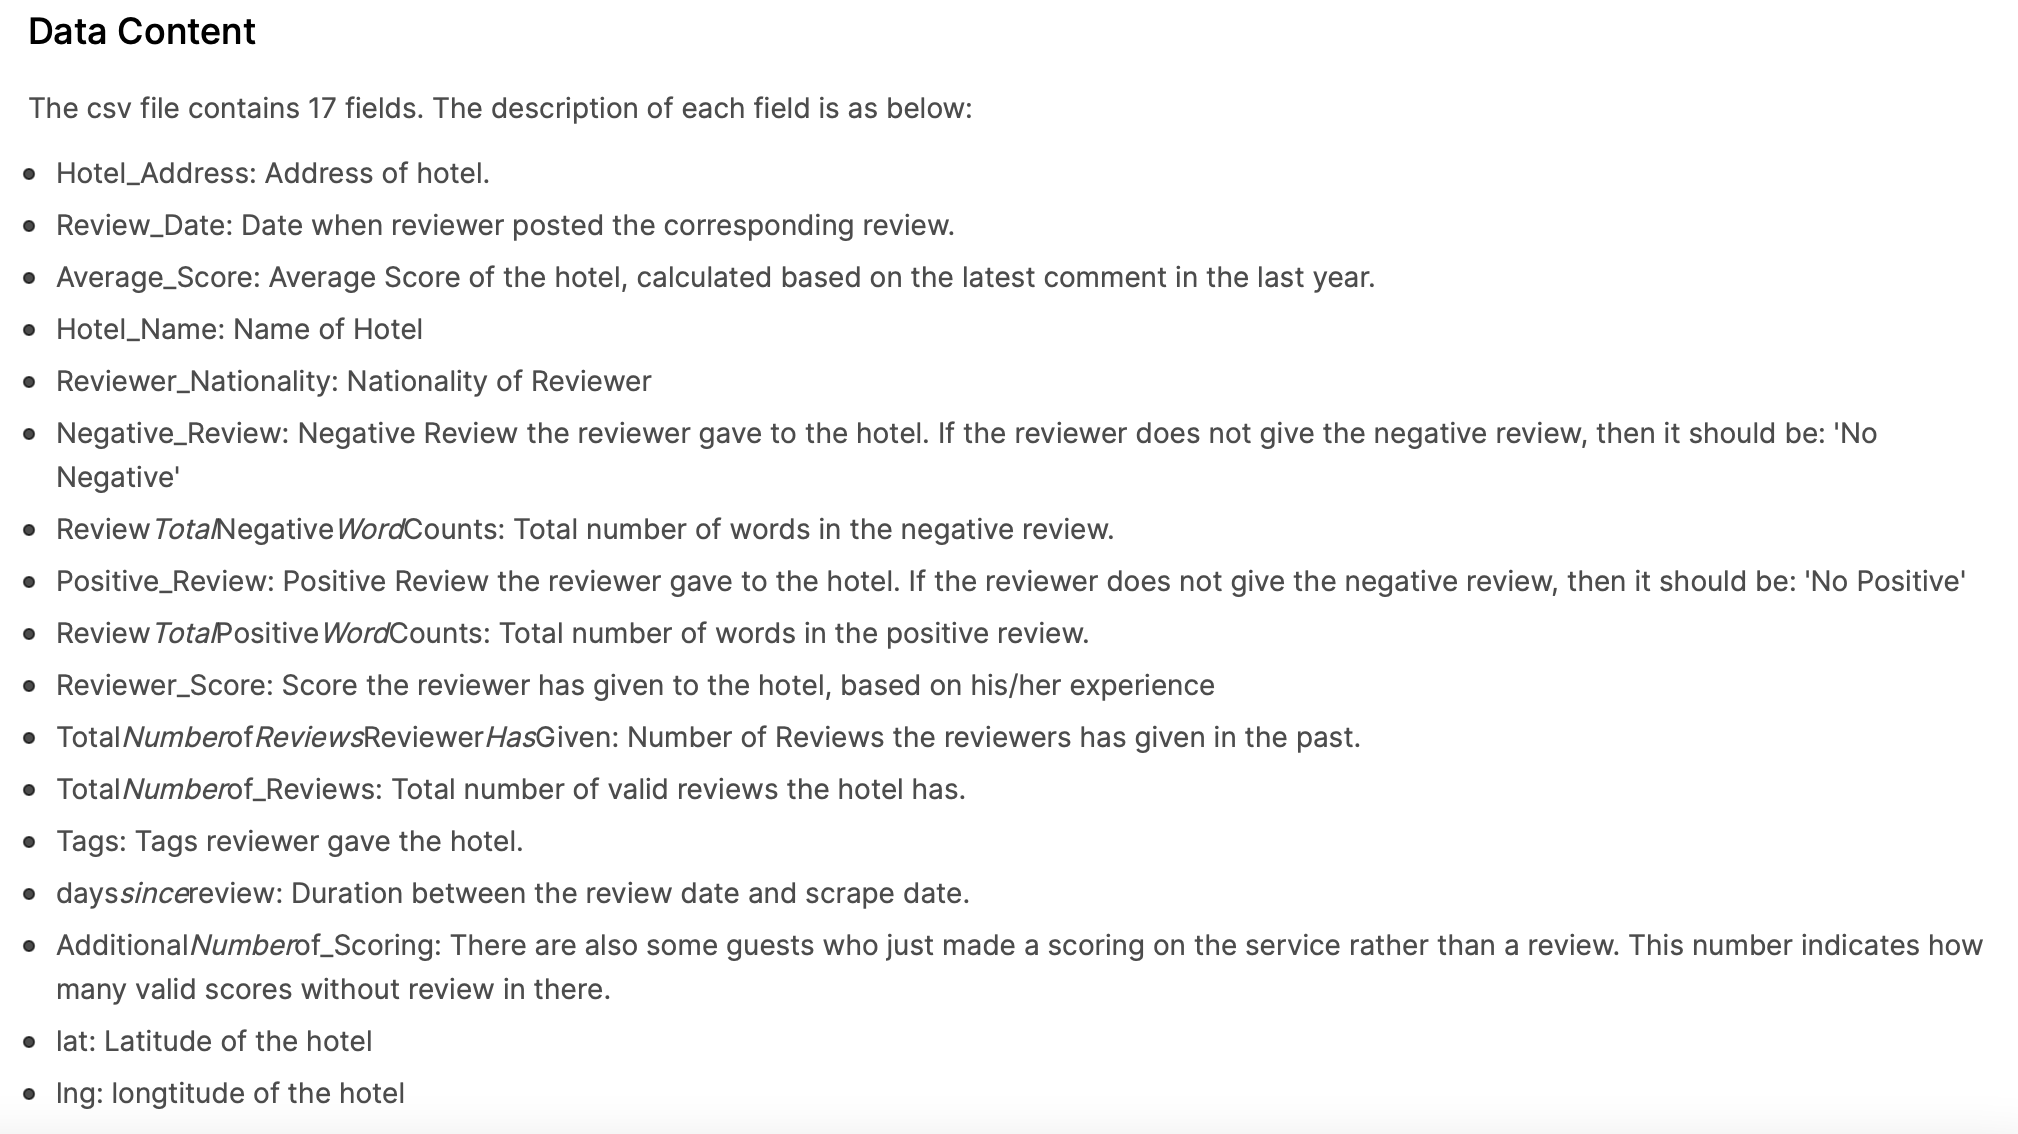

In [3]:
Image(r'/Users/larag/Documents/Ironhack/final_project/variables_explanation.png')

Drop Days_Since_Review as scrape date is in the past and thus not accurate:

In [4]:
df = df.drop(["days_since_review"], axis=1)

Drop Number of reviews and additional number of scoring as these columns are sums and will therefore vary when changing the time period. Will be (re-)calculated if needed:

In [5]:
df = df.drop(["Total_Number_of_Reviews"], axis=1)
df = df.drop(["Additional_Number_of_Scoring"], axis=1)

Drop average_score as it is not relevant to know the latest comment in the last year:

In [6]:
df = df.drop(["Average_Score"], axis=1)

## Inspecting and cleaning data

In [7]:
display(df.shape)
df.head().T

(515738, 13)

,0,1,2,3,4
Hotel_Address,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...
Review_Date,8/3/2017,8/3/2017,7/31/2017,7/31/2017,7/24/2017
Hotel_Name,Hotel Arena,Hotel Arena,Hotel Arena,Hotel Arena,Hotel Arena
Reviewer_Nationality,Russia,Ireland,Australia,United Kingdom,New Zealand
Negative_Review,I am so angry that i made this post available...,No Negative,Rooms are nice but for elderly a bit difficul...,My room was dirty and I was afraid to walk ba...,You When I booked with your company on line y...
Review_Total_Negative_Word_Counts,397,0,42,210,140
Positive_Review,Only the park outside of the hotel was beauti...,No real complaints the hotel was great great ...,Location was good and staff were ok It is cut...,Great location in nice surroundings the bar a...,Amazing location and building Romantic setting
Review_Total_Positive_Word_Counts,11,105,21,26,8
Total_Number_of_Reviews_Reviewer_Has_Given,7,7,9,1,3
Reviewer_Score,2.9,7.5,7.1,3.8,6.7


Make all column names lower case:

In [8]:
df.columns= df.columns.str.lower()
df.columns

Index(['hotel_address', 'review_date', 'hotel_name', 'reviewer_nationality',
       'negative_review', 'review_total_negative_word_counts',
       'positive_review', 'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'reviewer_score', 'tags',
       'lat', 'lng'],
      dtype='object')

Inspect information given in tags:

In [9]:
df.tags.value_counts()

[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']                                 5101
[' Leisure trip ', ' Couple ', ' Standard Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']                        4931
[' Leisure trip ', ' Couple ', ' Superior Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']                        4366
[' Leisure trip ', ' Couple ', ' Deluxe Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']                          3991
[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ', ' Submitted from a mobile device ']                                3291
                                                                                                                                        ... 
[' Business trip ', ' Couple ', ' Double Room 2 Adults ', ' Stayed 5 nights ']                                                             1
[' Leisure tr

Extract information from tags:

In [10]:
# type of trip:
df["leisure"] = df.tags.map(lambda x: 1 if ' Leisure trip ' in x else 0)
df["business"] = df.tags.map(lambda x: 1 if ' Business trip ' in x else 0)

# who is travelling:
df["couple"] = df.tags.map(lambda x: 1 if ' Couple ' in x else 0)
df["solo"] = df.tags.map(lambda x: 1 if ' Solo traveler ' in x else 0)
df["group"] = df.tags.map(lambda x: 1 if ' Group ' in x else 0)

# combine families with young and older children into "family":
df["familie"] = df.tags.map(lambda x: 1 if ' Family ' in x else 0)

# extract length of stay:
for i in range(len(df.tags)):
    df.at[i,"duration_stay"]  = re.findall(r'Stayed \d+', df.at[i,"tags"])
    df.at[i,"duration_stay"] = "".join(df.at[i,"duration_stay"]).strip("\Stayed ")

df["duration_stay"].unique()

array(['6', '4', '3', '2', '1', '5', '7', '10', '14', '9', '11', '8', '',
       '12', '16', '15', '13', '18', '17', '20', '21', '23', '25', '29',
       '28', '19', '26', '27', '24', '22', '30', '31'], dtype=object)

Make missing data more visible:

In [11]:
df["duration_stay"] = df["duration_stay"].replace('',"99")
df["duration_stay"].value_counts()

1     193645
2     133937
3      95821
4      47817
5      20845
6       9776
7       7399
8       2502
9       1293
10       889
11       418
12       316
14       247
13       246
99       192
15       117
16        57
17        42
18        33
19        29
21        23
20        19
27        11
30        11
23        10
22        10
25         7
26         7
28         7
24         6
29         5
31         1
Name: duration_stay, dtype: int64

Drop rows without duration of stay (indicated by 99) due to relatively small number:

In [12]:
indexNames = df[ df["duration_stay"] == "99" ].index
df.drop(indexNames , inplace=True)

Change type of column "duration stay" to integer and group all stays longer than a week (due to relativels small proportion of these stays):

In [13]:
df["duration_stay"] = df["duration_stay"].astype(str).astype(int)
df["duration_stay"].values[df["duration_stay"] > 7] = 8
df["duration_stay"].value_counts()

1    193645
2    133937
3     95821
4     47817
5     20845
6      9776
7      7399
8      6306
Name: duration_stay, dtype: int64

Look for nan in data:

In [14]:
df.isna().sum()

hotel_address                                    0
review_date                                      0
hotel_name                                       0
reviewer_nationality                             0
negative_review                                  0
review_total_negative_word_counts                0
positive_review                                  0
review_total_positive_word_counts                0
total_number_of_reviews_reviewer_has_given       0
reviewer_score                                   0
tags                                             0
lat                                           3267
lng                                           3267
leisure                                          0
business                                         0
couple                                           0
solo                                             0
group                                            0
familie                                          0
duration_stay                  

Inspect hotels with missing latitude and longitude: 

In [15]:
nan = pd.DataFrame(df[df.isnull().any(axis=1)])

print("Number of reviews without lat and lng:", len(nan["hotel_name"]))
print("Number of hotels without lat and lng:", nan["hotel_name"].nunique())

display("Names of hotels without lat and lng:", nan["hotel_name"].value_counts())

Number of reviews without lat and lng: 3267
Number of hotels without lat and lng: 17


'Names of hotels without lat and lng:'

Fleming s Selection Hotel Wien City                 658
Hotel City Central                                  563
Hotel Atlanta                                       389
Maison Albar Hotel Paris Op ra Diamond              290
Hotel Daniel Vienna                                 244
Hotel Pension Baron am Schottentor                  223
Austria Trend Hotel Schloss Wilhelminenberg Wien    194
Derag Livinghotel Kaiser Franz Joseph Vienna        147
NH Collection Barcelona Podium                      146
City Hotel Deutschmeister                            93
Hotel Park Villa                                     61
Cordial Theaterhotel Wien                            57
Holiday Inn Paris Montmartre                         55
Roomz Vienna                                         49
Mercure Paris Gare Montparnasse                      37
Renaissance Barcelona Hotel                          33
Hotel Advance                                        28
Name: hotel_name, dtype: int64

Create "nan dataframe" with hotel name and address:

In [16]:
nan = nan.drop_duplicates(subset=["hotel_name"]).reset_index(drop = False)
nan = nan[["hotel_name","hotel_address"]]
nan

,hotel_name,hotel_address
0,Mercure Paris Gare Montparnasse,20 Rue De La Ga t 14th arr 75014 Paris France
1,Holiday Inn Paris Montmartre,23 Rue Damr mont 18th arr 75018 Paris France
2,Maison Albar Hotel Paris Op ra Diamond,4 rue de la P pini re 8th arr 75008 Paris France
3,NH Collection Barcelona Podium,Bail n 4 6 Eixample 08010 Barcelona Spain
4,City Hotel Deutschmeister,Gr nentorgasse 30 09 Alsergrund 1090 Vienna Au...
5,Hotel Park Villa,Hasenauerstra e 12 19 D bling 1190 Vienna Austria
6,Fleming s Selection Hotel Wien City,Josefst dter Stra e 10 12 08 Josefstadt 1080 V...
7,Cordial Theaterhotel Wien,Josefst dter Stra e 22 08 Josefstadt 1080 Vien...
8,Hotel Daniel Vienna,Landstra er G rtel 5 03 Landstra e 1030 Vienna...
9,Roomz Vienna,Paragonstra e 1 11 Simmering 1110 Vienna Austria


There seems to be a problem with above addresses. Correct "typos" manually by looking up address online:

In [17]:
nan['hotel_address']=["20 Rue de la Gaité, 75014 Paris, France",
                     "23 Rue Damrémont, 75018 Paris, France",
                     "4 Rue de la Pépinière, 75008 Paris, France",
                     "C/ de Bailèn, 4-6, 08010 Barcelona, Spain",
                     "Grünentorgasse 30, 1090 Wien, Austria",
                     "Hasenauerstraße 12, 1190 Wien, Austria",
                     "Josefstädter Str. 10-12, 1080 Wien, Austria",
                     "Josefstädter Str. 22, 1080 Wien, Austria",
                     "Landstraßer Gürtel 5, 1030 Wien, Austria",
                     "Paragonstraße 1, 1110 Wien, Austria",
                     "Carrer de Pau Claris, 122, 08009 Barcelona, Spain",
                     "Savoyenstraße 2, 1160 Wien, Austria",
                     "Carrer de Sepúlveda, 180, 08011 Barcelona, Spain",
                     "Sieveringer Str. 4, 1190 Wien, Austria",
                     "Taborstraße 8, 1020 Wien, Austria",
                     "Währinger Str. 12, 1090 Wien, Austria",
                     "Währinger Str. 33-35, 1090 Wien, Austria"]

nan

,hotel_name,hotel_address
0,Mercure Paris Gare Montparnasse,"20 Rue de la Gaité, 75014 Paris, France"
1,Holiday Inn Paris Montmartre,"23 Rue Damrémont, 75018 Paris, France"
2,Maison Albar Hotel Paris Op ra Diamond,"4 Rue de la Pépinière, 75008 Paris, France"
3,NH Collection Barcelona Podium,"C/ de Bailèn, 4-6, 08010 Barcelona, Spain"
4,City Hotel Deutschmeister,"Grünentorgasse 30, 1090 Wien, Austria"
5,Hotel Park Villa,"Hasenauerstraße 12, 1190 Wien, Austria"
6,Fleming s Selection Hotel Wien City,"Josefstädter Str. 10-12, 1080 Wien, Austria"
7,Cordial Theaterhotel Wien,"Josefstädter Str. 22, 1080 Wien, Austria"
8,Hotel Daniel Vienna,"Landstraßer Gürtel 5, 1030 Wien, Austria"
9,Roomz Vienna,"Paragonstraße 1, 1110 Wien, Austria"


Get missing latitude and longitude:

In [18]:
# source: https://geopy.readthedocs.io/en/stable/#geopy.geocoders.AlgoliaPlaces.geocode

from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="my_user_agent")

for i in range(len(nan)):
    nan.at[i,"latitude"] = geolocator.geocode(nan.at[i,"hotel_address"]).latitude
    nan.at[i,"longitude"] = geolocator.geocode(nan.at[i,"hotel_address"]).longitude
    
nan = nan.drop("hotel_address", axis=1)

Merge tables and replace nan:

In [19]:
df = pd.merge(df, nan, on='hotel_name', how='left')
df = df.assign(new_lng = lambda x: np.where(x.lng.isna()==True, x.longitude,x.lng))
df = df.assign(new_lat = lambda x: np.where(x.lat.isna()==True, x.latitude,x.lat))

Check for duplicates in the data + remove duplicate rows: 

In [20]:
display(sum(df.duplicated()))

df = df.drop_duplicates()

526

In [21]:
df = df.drop(["latitude","longitude"], axis=1)

## Datatypes

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515020 entries, 0 to 515545
Data columns (total 22 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515020 non-null  object 
 1   review_date                                 515020 non-null  object 
 2   hotel_name                                  515020 non-null  object 
 3   reviewer_nationality                        515020 non-null  object 
 4   negative_review                             515020 non-null  object 
 5   review_total_negative_word_counts           515020 non-null  int64  
 6   positive_review                             515020 non-null  object 
 7   review_total_positive_word_counts           515020 non-null  int64  
 8   total_number_of_reviews_reviewer_has_given  515020 non-null  int64  
 9   reviewer_score                              515020 non-null  float64
 

Change review_date into date format:

In [23]:
df["review_date"] = pd.to_datetime(df["review_date"], errors='coerce').dt.date

## 15 best places to travel in Europe in 2016 (webscraping)

Dataset has reviews from Aug 15 to Aug 17. Webscraping top travel destinations in Europe 2016 (relatively small portion of reviews in 2015 + expected that top destinations in 2016 will also affect "travel behaviour" in 2017).

In [24]:
url = "https://www.europeanbestdestinations.com/best-of-europe/european-best-destinations-2016/"

In [25]:
response = requests.get(url)
response.status_code 

200

In [26]:
soup = BeautifulSoup(response.content, "html.parser")
soup 

<!DOCTYPE html>

<html lang="en-US"><head>
<meta charset="utf-8"/>
<link crossorigin="anonymous" href="https://u.jimcdn.com/" rel="dns-prefetch preconnect"/>
<link crossorigin="anonymous" href="https://assets.jimstatic.com/" rel="dns-prefetch preconnect"/>
<link crossorigin="anonymous" href="https://image.jimcdn.com" rel="dns-prefetch preconnect"/>
<link crossorigin="anonymous" href="https://www.google-analytics.com" rel="dns-prefetch preconnect"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible"/>
<meta content="From Zadar to Milan, travellers have selected the best places to visit in Europe. Discover now the best destinations to travel this year !" name="description"/>
<meta content="index, follow, archive" name="robots"/>
<meta content="From Zadar to Milan, travellers have selected the best places to visit in Europe. Discover now the best destinations to travel this year !" property="st:section"/>
<meta content="Best places to travel in 2016" name="twitter:title"/>
<meta content

In [27]:
soup.select("h2.destination")

[<h2 class="destination">
     1. Zadar in Croatia
 </h2>,
 <h2 class="destination">
     2. Athens
 </h2>,
 <h2 class="destination">
     3. Plovdiv
 </h2>,
 <h2 class="destination">
     4. Nantes
 </h2>,
 <h2 class="destination">
     5. Azores
 </h2>,
 <h2 class="destination">
     6. Paris
 </h2>,
 <h2 class="destination">
     7. Novi Sad
 </h2>,
 <h2 class="destination">
     8. Brussels
 </h2>,
 <h2 class="destination">
     9. Kotor
 </h2>,
 <h2 class="destination">
     10. Milan
 </h2>,
 <h2 class="destination">
     11. Prague
 </h2>,
 <h2 class="destination">
     12. Rome
 </h2>,
 <h2 class="destination">
     13. Vienna
 </h2>,
 <h2 class="destination">
     15. Nicosia
 </h2>]

In [28]:
city = []
country = []

num_iter = len(soup.select("h2.destination"))

for i in range(num_iter):
    city.append(soup.select("h2.destination")[i].get_text().strip("\n"))
    country.append(soup.select("p.country")[i].get_text().strip("\n"))
    
top_dest = pd.DataFrame({"city":city,
                       "country":country
                      })
top_dest

,city,country
0,1. Zadar in Croatia,European Best Destination 2016
1,2. Athens,Greece
2,3. Plovdiv,Bulgaria
3,4. Nantes,France
4,5. Azores,Portugal
5,6. Paris,France
6,7. Novi Sad,Serbia
7,8. Brussels,Belgium
8,9. Kotor,Montenegro
9,10. Milan,Italy


Correct first row:

In [29]:
top_dest.country[0] = top_dest.country[0].replace("European Best Destination 2016","Croatia")
top_dest.city[0] = top_dest.city[0][:12]

Keep only city names (drop number):

In [30]:
# https://stackoverflow.com/questions/8199398/extracting-only-characters-from-a-string-in-python

for i in range(len(top_dest)):
    top_dest.at[i,"city"] = "".join(re.findall("[a-zA-Z]+", top_dest.at[i,"city"]))

In [31]:
top_dest

,city,country
0,Zadar,Croatia
1,Athens,Greece
2,Plovdiv,Bulgaria
3,Nantes,France
4,Azores,Portugal
5,Paris,France
6,NoviSad,Serbia
7,Brussels,Belgium
8,Kotor,Montenegro
9,Milan,Italy


## Storing cleaned dataset

### To csv

In [32]:
df.to_csv('hotel_reviews_cleaned.csv')

In [33]:
top_dest.to_csv('top_destinations_2016.csv')

### To SQL

In [34]:
password = getpass.getpass()

········


In [35]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/hotel_reviews'
engine = create_engine(connection_string)

In [36]:
df.to_sql('reviews', if_exists = 'replace', con = engine, index=False)

In [37]:
top_dest.to_sql('top_dest16', if_exists = 'replace', con = engine, index=False)

## Extracting Information from SQL 

In [38]:
df.columns

Index(['hotel_address', 'review_date', 'hotel_name', 'reviewer_nationality',
       'negative_review', 'review_total_negative_word_counts',
       'positive_review', 'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'reviewer_score', 'tags',
       'lat', 'lng', 'leisure', 'business', 'couple', 'solo', 'group',
       'familie', 'duration_stay', 'new_lng', 'new_lat'],
      dtype='object')

#### Focus on 2016 (Jan - Dec):

In [39]:
df16 = pd.read_sql_query('''SELECT 

                                r.hotel_name,
                                r.hotel_address,
                                r.reviewer_score,

                                EXTRACT(week from r.review_date) as week,
                                EXTRACT(month from r.review_date) as month,
                            
                                r.duration_stay,
                                
                                r.leisure, 
                                r.business, 
                                
                                r.couple,
                                r.solo,
                                r.group, 
                                r.familie,
                                
                                r.reviewer_nationality, 
                                r.total_number_of_reviews_reviewer_has_given,
                                
                                r.negative_review, 
                                r.positive_review, 
                                
                                r.lat,
                                r.lng

                                FROM hotel_reviews.reviews r

                                WHERE r.review_date LIKE '2016-%%'
                                '''
                          ,engine)

In [40]:
df16.head().T

,0,1,2,3,4
hotel_name,Hotel Arena,Hotel Arena,Hotel Arena,Hotel Arena,Hotel Arena
hotel_address,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...
reviewer_score,9.2,7.5,7.9,8.8,6.7
week,52,52,51,51,51
month,12,12,12,12,12
duration_stay,3,4,4,2,2
leisure,1,1,1,1,1
business,0,0,0,0,0
couple,1,1,1,1,1
solo,0,0,0,0,0


### Top hotels in 2016

In [41]:
hotels_reviewed = df16.hotel_name.nunique()
reviews_given = df16.reviewer_nationality.count()

print("Number of hotels reviewed in 2016:", hotels_reviewed)
print("Number of reviews given in 2016:", reviews_given)

Number of hotels reviewed in 2016: 1457
Number of reviews given in 2016: 264075


#### Top 25 - Most reviews 

In [42]:
pd.set_option('display.max_rows', None)

print("Top 25 - hotels with most reviews:")

df16.hotel_name.value_counts().head(25)

Top 25 - hotels with most reviews:


Strand Palace Hotel                                  2328
Park Plaza Westminster Bridge London                 2267
Britannia International Hotel Canary Wharf           2221
Copthorne Tara Hotel London Kensington               1829
Grand Royale London Hyde Park                        1609
Intercontinental London The O2                       1561
Holiday Inn London Kensington                        1535
DoubleTree by Hilton Hotel London Tower of London    1498
Millennium Gloucester Hotel London                   1347
Hilton London Metropole                              1280
Hilton London Wembley                                1264
Park Grand Paddington Court                          1215
Hilton London Kensington Hotel                       1186
Park Grand London Kensington                         1180
Park Plaza County Hall London                        1142
DoubleTree by Hilton London Docklands Riverside      1130
St James Court A Taj Hotel London                    1084
Blakemore Hyde

#### Top 25 - best reviewer score

In [43]:
top_hotels = df16.groupby(by = ["hotel_name"]).agg({"reviewer_score":"mean",
                                                    "lat":"count"}
            ).sort_values("reviewer_score", ascending = False
                         ).reset_index(drop = False).rename(columns={"lat":"no_reviews",
                                           "reviewer_score":"avg_score"})

print("Top 25 - hotels with best review score")

top_hotels.head(25)

Top 25 - hotels with best review score


,hotel_name,avg_score,no_reviews
0,Maison Albar Hotel Paris C line,10.000000,1
1,The Level at Melia Barcelona Sky,10.000000,1
2,Sir Adam Hotel,9.866667,3
3,Hotel Casa Camper,9.752991,117
4,Renaissance Paris Republique Hotel Spa,9.700000,4
5,Hollmann Beletage Design Boutique,9.682000,50
6,45 Park Lane Dorchester Collection,9.653846,13
7,41,9.652083,48
8,Le Narcisse Blanc Spa,9.644444,18
9,Hotel The Serras,9.641228,114


#### Key finding:

1. Top 15 hotels based on reviewer_score have a relatively small number of total reviews. 


2. A small number of reviews makes the review score  prone to bias, e.g.:
   
   a) positive bias due to personal connection with, for instance, owner/manager 
  
  b) negative bias due to "bad luck", for instance, construction work close by 

Thus, take a closer look at no_reviews per hotel.

In [44]:
# Calculate number of reviews for each hotel:
df_no_reviews = df16.groupby(by = ["hotel_name"]).agg({"lat":"count"}).sort_values(
    "lat", ascending = False).reset_index(drop = False).rename(columns={"lat":"no_reviews"})

# Merge tables:
df16 = pd.merge(df16, df_no_reviews, on='hotel_name', how='left')

# Look at distribution of number of reviews:
display(df16.no_reviews.describe())
display(df16.no_reviews.quantile(.1))

count    264075.000000
mean        486.398474
std         467.230180
min           0.000000
25%         169.000000
50%         359.000000
75%         622.000000
max        2328.000000
Name: no_reviews, dtype: float64

79.0

#### Key findings:

1. Top 25: Only 3 hotels are not in the 10% 
2. Top 25: all hotels are in Q1
3. Q1: 170 reviews (i.e. a review is given about every other day)

Q1 will be taken as a cut off point and only hotels with more than 170 reviews will be considered for future analysis. 

Create new (reduced, r) dataframe:

In [45]:
df16r = df16[df16["no_reviews"]> 170]

display("After removing hotels with very small number of reveiws:")

hotels_reviewed_r = df16r.hotel_name.nunique()
reviews_given_r = df16r.reviewer_nationality.count()

print("Number of hotels reviewed in 2016:", hotels_reviewed_r)
print("Number of reviews given in 2016:", reviews_given_r)

print("Reduction of number of reviewed hotels by", hotels_reviewed - hotels_reviewed_r) 
print("Reduction of number of reviews given by", reviews_given - reviews_given_r) 

'After removing hotels with very small number of reveiws:'

Number of hotels reviewed in 2016: 477
Number of reviews given in 2016: 196411
Reduction of number of reviewed hotels by 980
Reduction of number of reviews given by 67664


### Top 100 hotels - average reviewer score:

In [46]:
# Calculate average review score for each hotel:
df_avg_rev_score = df16r.groupby(by = ["hotel_name"]
                            ).agg({"reviewer_score":"mean"}
                                   ).sort_values("reviewer_score",ascending = False
                                                ).reset_index(drop = False
                                                             ).rename(columns={
    "reviewer_score":"avg_rev_score"})

# Merge tables:
df16r = pd.merge(df16r, df_avg_rev_score, on='hotel_name', how='left')

In [47]:
# Creat new dataframe "hotels":
hotels = df16r.groupby(by = ["hotel_name"]).max().sort_values(
    "avg_rev_score",ascending=False).reset_index(drop = False)[["hotel_name",
                                                                "avg_rev_score",
                                                               "lat", "lng",
                                                               "leisure",
                                                               "business"]]

print("Top 100 hotels - based on average review score in 2016")
hotels.head(100)

Top 100 hotels - based on average review score in 2016


,hotel_name,avg_rev_score,lat,lng,leisure,business
0,Catalonia Magdalenes,9.516749,41.386128,2.174529,1,1
1,The Toren,9.512273,52.375875,4.885964,1,1
2,Catalonia Square 4 Sup,9.489381,41.388566,2.171299,1,1
3,Rosewood London,9.474227,51.517330,-0.118097,1,1
4,Batty Langley s,9.466111,51.520857,-0.077950,1,1
5,The Hoxton Amsterdam,9.443969,52.371867,4.887379,1,1
6,Olivia Balmes Hotel,9.437544,41.392095,2.158493,1,1
7,Hotel Palace GL,9.436735,41.391626,2.171638,1,1
8,Excelsior Hotel Gallia Luxury Collection Hotel,9.433140,45.485703,9.202013,1,1
9,Amba Hotel Charing Cross,9.427132,51.508236,-0.126196,1,1


#### Key finding:

Almost all hotels in the top 100 have a score above 9.0.

What about the location ?

### Add location:

In [48]:
for i in range(len(hotels)):
    
    location = geolocator.reverse(str(hotels.lat[i])+","+str(hotels.lng[i]), language='en')
  
    address = location.raw['address']
    hotels.at[i,"city"] = address.get('city', '') 
    hotels.at[i,"country"] = address.get('country', '')

In [49]:
hotels.head()

,hotel_name,avg_rev_score,lat,lng,leisure,business,city,country
0,Catalonia Magdalenes,9.516749,41.386128,2.174529,1,1,Barcelona,Spain
1,The Toren,9.512273,52.375875,4.885964,1,1,Amsterdam,Netherlands
2,Catalonia Square 4 Sup,9.489381,41.388566,2.171299,1,1,Barcelona,Spain
3,Rosewood London,9.474227,51.517330,-0.118097,1,1,London,United Kingdom
4,Batty Langley s,9.466111,51.520857,-0.077950,1,1,London,United Kingdom


In [50]:
display(hotels.city.unique())
display(hotels.country.unique())

# rename City of London to London to align city name:

for i in range(len(hotels)):
    if hotels.at[i,"city"] == "City of London":
        hotels.at[i,"city"] = "London"
        
    elif hotels.at[i,"city"] == "Westminster":
        hotels.at[i,"city"] = "London"
        
    else:
        hotels.at[i,"city"] = hotels.at[i,"city"]
        
display(hotels.city.unique())

array(['Barcelona', 'Amsterdam', 'London', 'Milan', 'Westminster',
       'City of London', '', 'Paris', 'Vienna'], dtype=object)

array(['Spain', 'Netherlands', 'United Kingdom', 'Italy', 'Austria',
       'France'], dtype=object)

array(['Barcelona', 'Amsterdam', 'London', 'Milan', '', 'Paris', 'Vienna'],
      dtype=object)

Inspect empty space for city:

In [51]:
hotels[hotels["city"]== ""]

,hotel_name,avg_rev_score,lat,lng,leisure,business,city,country
36,Hotel Capricorno,9.236170,48.211152,16.378863,1,1,,Austria
39,Hotel Kaiserin Elisabeth,9.220465,48.207235,16.372238,1,1,,Austria
52,Hotel Stefanie,9.147222,48.214277,16.380178,1,1,,Austria
57,Hotel Am Parkring,9.110900,48.205633,16.377862,1,1,,Austria
75,Hotel Das Tigra,9.024876,48.212177,16.368077,1,1,,Austria
85,Steigenberger Hotel Herrenhof,9.000358,48.209796,16.365870,1,1,,Austria
90,25hours Hotel beim MuseumsQuartier,8.993976,48.206474,16.354630,1,1,,Austria
100,Austria Trend Hotel Savoyen Vienna,8.936875,48.195044,16.384475,1,1,,Austria
115,NH Collection Wien Zentrum,8.856284,48.197998,16.348331,1,1,,Austria
120,Hotel Erzherzog Rainer,8.840752,48.195323,16.367288,1,1,,Austria


Only 1 hotel in Italy has no information regarding the city. In this case, the hotel name includes the location. Thus, empty string is replaced with Milan.

The remaining hotels are in Austria. Some hotel names include the location, i.e. Vienna. All hotels seem to be in Vienna as latitude and longitude are very similiar. Thus, empty strings are replaced with Vienna.

In [52]:
# Make empty strings more visible: 
hotels["city"] = hotels["city"].replace(r'^\s*$', np.NaN, regex=True)

# Replace nan:
hotels["city"].loc[(hotels["country"] == "Italy"
               ) & (hotels["city"].isna()== True)] = "Milan"

hotels["city"].loc[(hotels["country"] == "Austria"
               ) & (hotels["city"].isna()== True)] = "Vienna"

hotels.head()

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,hotel_name,avg_rev_score,lat,lng,leisure,business,city,country
0,Catalonia Magdalenes,9.516749,41.386128,2.174529,1,1,Barcelona,Spain
1,The Toren,9.512273,52.375875,4.885964,1,1,Amsterdam,Netherlands
2,Catalonia Square 4 Sup,9.489381,41.388566,2.171299,1,1,Barcelona,Spain
3,Rosewood London,9.474227,51.517330,-0.118097,1,1,London,United Kingdom
4,Batty Langley s,9.466111,51.520857,-0.077950,1,1,London,United Kingdom


In [53]:
hotels

,hotel_name,avg_rev_score,lat,lng,leisure,business,city,country
0,Catalonia Magdalenes,9.516749,41.386128,2.174529,1,1,Barcelona,Spain
1,The Toren,9.512273,52.375875,4.885964,1,1,Amsterdam,Netherlands
2,Catalonia Square 4 Sup,9.489381,41.388566,2.171299,1,1,Barcelona,Spain
3,Rosewood London,9.474227,51.517330,-0.118097,1,1,London,United Kingdom
4,Batty Langley s,9.466111,51.520857,-0.077950,1,1,London,United Kingdom
5,The Hoxton Amsterdam,9.443969,52.371867,4.887379,1,1,Amsterdam,Netherlands
6,Olivia Balmes Hotel,9.437544,41.392095,2.158493,1,1,Barcelona,Spain
7,Hotel Palace GL,9.436735,41.391626,2.171638,1,1,Barcelona,Spain
8,Excelsior Hotel Gallia Luxury Collection Hotel,9.433140,45.485703,9.202013,1,1,Milan,Italy
9,Amba Hotel Charing Cross,9.427132,51.508236,-0.126196,1,1,London,United Kingdom


In [54]:
hotels.groupby(by = "city").agg({"avg_rev_score":"mean",
                                                  "country":"count"}
                                   ).sort_values("country", ascending = False
                         ).reset_index(drop = False).rename(columns={"country":"no_hotels"})

,city,avg_rev_score,no_hotels
0,London,8.407390,248
1,Barcelona,8.576409,70
2,Amsterdam,8.398641,65
3,Vienna,8.523454,41
4,Milan,8.411141,34
5,Paris,8.358895,19


### Key findings:

1. All hotels are in European capitals
2. Hotels in London have, by far, received the most reviews
3. Across capitals, average reviews scores are very similar (highest: Barcelona / lowest: Paris)

#### Save dataframe hotels to csv and sql

In [55]:
hotels.to_csv('hotels16.csv')
hotels.to_sql('hotels16', if_exists = 'replace', con = engine, index=False)

#### Extract infos from sql (incl. top destination flag):

In [56]:
df_hotels = pd.read_sql_query('''SELECT 

                                h.hotel_name,
                                h.avg_rev_score,
                                
                                h.city,
                                h.country,
                                
                                h.leisure,
                                h.business,
                                
                                CASE WHEN h.city = t.city then 1 
                                else 0 end as top_dest
                            
                                FROM hotel_reviews.hotels16 h
                                
                                LEFT JOIN hotel_reviews.top_dest16 t
                                ON t.city = h.city
        
                                '''
                          ,engine)

Find hotels in 2016's most popular destinations:

In [57]:
top_dest_hotels = df_hotels[df_hotels["top_dest"]==1]

top_dest_hotels.head(10)

,hotel_name,avg_rev_score,city,country,leisure,business,top_dest
8,Excelsior Hotel Gallia Luxury Collection Hotel,9.433140,Milan,Italy,1,1,1
13,Hotel Berna,9.402742,Milan,Italy,1,1,1
21,Room Mate Giulia,9.353134,Milan,Italy,1,1,1
36,Hotel Capricorno,9.236170,Vienna,Austria,1,1,1
39,Hotel Kaiserin Elisabeth,9.220465,Vienna,Austria,1,1,1
43,H tel Regina,9.190206,Paris,France,1,1,1
52,Hotel Stefanie,9.147222,Vienna,Austria,1,1,1
54,The Square Milano Duomo,9.124161,Milan,Italy,1,1,1
57,Hotel Am Parkring,9.110900,Vienna,Austria,1,1,1
64,COQ Hotel Paris,9.078857,Paris,France,1,1,1


In [58]:
top_dest_hotels.groupby(by=["city"]).agg({"avg_rev_score":"mean",
                                                    "leisure":"count"}
            ).sort_values("avg_rev_score", ascending = False
                         ).reset_index(drop = False).rename(columns={"leisure":"no_hotels"})

,city,avg_rev_score,no_hotels
0,Vienna,8.523454,41
1,Milan,8.411141,34
2,Paris,8.358895,19


#### Key findings:

Looking at the most popular destinations in 2016, hotels in Vienna received not only the most reviews but also the best average review scores. 

#### Looking at all cities next:

In [59]:
df_hotels.groupby(by=["city"]).agg({"avg_rev_score":"mean",
                                                    "leisure":"count"}
            ).sort_values("avg_rev_score", ascending = False
                         ).reset_index(drop = False).rename(columns={"leisure":"no_hotels"})

,city,avg_rev_score,no_hotels
0,Barcelona,8.576409,70
1,Vienna,8.523454,41
2,Milan,8.411141,34
3,London,8.407390,248
4,Amsterdam,8.398641,65
5,Paris,8.358895,19


#### Key findings:

1. City with the highest average hotel score is not a top destination
2. Difference between average hotel score of Barcelona ("best") and Paris ("worst") is less than 0.25.

#### Thus, closer look at distribution of reviewers' score across all hotels:

In [60]:
df_hotels.avg_rev_score.describe()

count    477.000000
mean       8.439313
std        0.588987
min        6.381624
25%        8.094577
50%        8.499519
75%        8.841694
max        9.516749
Name: avg_rev_score, dtype: float64

 #### Key findings:
 
 1. About 75% of all reviewed hotels have an average score above 8 
 2. About 50 % of all reviewed hotels have an average score above 8.5
 3. Only 25 % of all reviewed hotel have an average score below 8 

-> Look into positive and negative reviews to get more insights.

## Inspect Review Comments 

### Wordcloud

In [61]:
from PIL import Image

In [62]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def wordcloud_neg(data, title = None):
    
    mask = np.array(Image.open("thumbsdown.png"))
    
    wordcloud = WordCloud(background_color = 'white', mask = mask, max_words = 150,
                          max_font_size = 60, scale = 5
                         ).generate(str(data))

    fig = plt.figure(1, figsize = (8, 8))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.savefig('wordcloud_neg_rev.jpg')
    plt.show()

#### Wordcloud negative reviews:

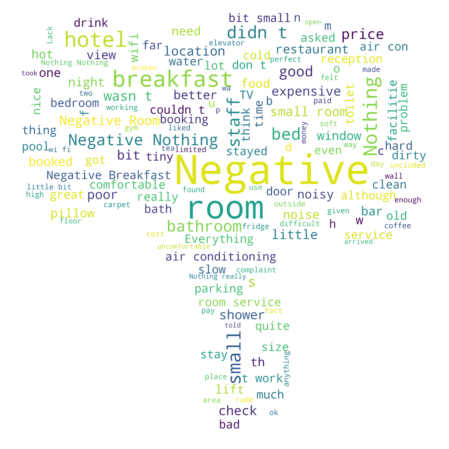

In [63]:
wordcloud_neg_rev = wordcloud_neg(df16r["negative_review"])
wordcloud_neg_rev 

#### Wordcloud positive reviews:

In [64]:
def wordcloud_pos(data, title = None):
    
    mask = np.array(Image.open("thumbsup.png"))
    
    wordcloud = WordCloud(background_color = 'white', mask = mask, max_words = 150,
                          max_font_size = 60, scale = 5
                         ).generate(str(data))

    fig = plt.figure(1, figsize = (8, 8))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.savefig('wordcloud_pos_rev.jpg')
    plt.show()

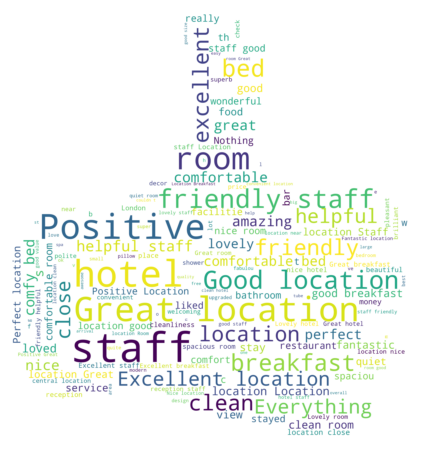

In [65]:
wordcloud_pos_rev = wordcloud_pos(df16r["positive_review"])
wordcloud_pos_rev

#### Key findings:

1. Comments tend to be either related to the hotel itself or to customer experience  

2. Hotel: location, room, food, staff

3. Customer experience: postive (e.g. lovely, great, perfect) and negative (e.g. noisy, uncomfortable, missing) 
 

### Closer look at reviews

Define function to estimate positive/negative impact of certain words in review comments on average reviewer score:

In [66]:
def neg_impact_calculator(any_list_of_words):
    
    impact_list = []
    
    for item in any_list_of_words:
        a = (df16r.assign(whats_this = lambda x: np.where(
            x.negative_review.str.contains(item),1,0))
             .groupby(by="whats_this")
             .agg({"avg_rev_score":"mean"})).reset_index(drop=True)
        
        if len(a)>1:
            impact = a.at[1,"avg_rev_score"]-a.at[0,"avg_rev_score"]
            impact_list.append(impact)
        
        else:
            impact_list.append(np.nan)
    
    return impact_list

In [67]:
def pos_impact_calculator(any_list_of_words):
    
    impact_list = []
    
    for item in any_list_of_words:
        a = (df16r.assign(whats_this = lambda x: np.where(
            x.positive_review.str.contains(item),1,0))
             .groupby(by="whats_this")
             .agg({"avg_rev_score":"mean"})).reset_index(drop=True)
        
        if len(a)>1:
            impact = a.at[1,"avg_rev_score"]-a.at[0,"avg_rev_score"]
            impact_list.append(impact)
        
        else:
            impact_list.append(np.nan)
    
    return impact_list

### Location, room, breakfast and staff -  significant postive or negative impact ?

Create lists with "neutral words":

In [68]:
room = ["room", "bedroom", "bed","bathroom", "wifi", "cleanliness"]
food = ["breakfast", "dinner"]
location = ["location"]
staff = ["staff"]

#### Impact of room:

In [69]:
display("negative", neg_impact_calculator(room), "positive", pos_impact_calculator(room))

'negative'

[-0.20385678351398262,
 -0.16571360979734173,
 -0.21602285579584368,
 -0.2028947617534662,
 -0.29999634500303785,
 -0.24795994891410267]

'positive'

[0.10539031191301262,
 0.11948054384985873,
 0.0866555316080575,
 0.10471277602928453,
 0.01092646856418611,
 0.05828281978166849]

#### Key findings:

1. Bed, wifi, cleanliness seem to have no significant positive impact but have a relatively strong negative impact on the review score. 
2. Room and bathroom do have a positive impact but the negative impact in both cases is twice as high.
3. Room features seem to be considered as standard. Only if the standard is not met, the reviewers' score is influenced. This particularly true for wifi: pos impact is almost 0 (0,01) but neg impact is close to - 0,3. 

#### Impact of food:

In [70]:
display("negative:", neg_impact_calculator(food), "positive", pos_impact_calculator(food))

'negative:'

[-0.03162046878933289, 0.07297204191594808]

'positive'

[0.01668626169370846, 0.21003679222874894]

#### Key findings: 

1. Overall, food does not seem to be an important factor.
2. Exception: if the dinner is good, it improves the review score significantly.

#### Impact of location:

In [71]:
display("negative:", neg_impact_calculator(location), "positive", pos_impact_calculator(location))

'negative:'

[-0.08464530578795326]

'positive'

[0.030079720326657622]

#### Key findings:

Location seemed to be an important factor when visually inspecting "buzzwords" in (positive) comments. However, it turns out to have no impact (neither positive nor negative) on the review score. 

#### Impact of staff:

In [72]:
display("negative:", neg_impact_calculator(staff), "positive", pos_impact_calculator(staff))

'negative:'

[-0.1292165630148805]

'positive'

[0.13012684830802712]

#### Key findings:

Similarly to location, staff seemed to be an important factor when inspecting wordclouds of negative and postive comments. However, the impact on the reviewers' scores is low (negative and positive impact are about the same). 

### Customer experience -  significant postive or negative impact ?

Create lists with "positive and negative words" (15 each):

In [73]:
neg_exp = ["loud", "noisy", "noise", "dirty", "small", "hard", "missing", "broken", 
           "ask", "don't", "expensive", "bad", "uncomfortable", "cold", "slow"]

pos_exp = ["quiet", "clean", "spacious", "comfortable", "helpful", "friendly","great",
           "lovely","loved", "nice", "perfect", "good", "excellent", "liked", "likes"]

#### Impact of negative expressions:

In [74]:
display(neg_impact_calculator(neg_exp))

[-0.07829214207099433,
 -0.17566174865715034,
 -0.16285599600367284,
 -0.39636766343662266,
 -0.2183422822702994,
 -0.12967130730990561,
 -0.14021461359489074,
 -0.39733500519793363,
 -0.11330707116986538,
 nan,
 0.045447380749887856,
 -0.19839852188355422,
 -0.24048664307236578,
 -0.15376962360275925,
 -0.06683579485027558]

#### Key findings: 

There is further evidence for the hypothesis that reviewers have certain expectations about a hotel and that the hotel score will be negatively affected if these stadards are not met:  

1. dirty and broken: almost -0,4 (each)
2. noise,noisy,laut: above - 0,41 (combined)
3. uncomfortable: about - 0,25

#### Impact of positive expressions:

In [75]:
display(pos_impact_calculator(pos_exp))

[0.0791679253061286,
 0.026744475436220938,
 0.09936325469429264,
 0.09832261951405918,
 0.08849268514433994,
 0.09900617533985567,
 0.12685207519996666,
 0.1295853935396334,
 0.23106307828745543,
 0.027827693917213736,
 0.14427705066647079,
 -0.053996804678162036,
 0.12383091579920524,
 0.030457548796643863,
 0.12238472172870196]

#### Key findings:

In line with previous findings, only things that are far above average and are probably even better than expected have a positive impact on the reviewers score, e.g.

1. lovely and loved: + 0,36 (combined)
2. perfect: about 0,15
3. excellent and likes: about 0,12 (each)


#### Overall: 

1. There is strong evidence that hotel guests have a certain expectation and the review score will only be affected if these expectations are not met. 

2. Negative deviations from expectations have a far stronger impact than positive deviations.

3. Only extraordinary things that describe as "lovely/loved", have a significant positive impact.

#### Next step(s): 

Is there a difference depending on reviewer nationality, occasion of travelling and length of stay ? 

## Looking at reviewers 

### Nationality

In [76]:
df16r.reviewer_nationality.describe()

count               196411
unique                 207
top        United Kingdom 
freq                107139
Name: reviewer_nationality, dtype: object

In [77]:
df16r.reviewer_nationality.value_counts()

 United Kingdom                           107139
 United States of America                  10686
 Australia                                  7336
 Ireland                                    5888
 United Arab Emirates                       3255
 Netherlands                                2896
 Saudi Arabia                               2890
 Switzerland                                2841
 Canada                                     2664
 Germany                                    2660
 Israel                                     2333
 France                                     2309
 Belgium                                    1972
 Italy                                      1958
 Turkey                                     1827
 Kuwait                                     1773
 Spain                                      1593
 Romania                                    1463
 Sweden                                     1206
 Greece                                     1172
 New Zealand        

More than half of the reviews are given by UK citizens. 

Groupe reviewers nationality by continent. 

Inspect and clean country names:

In [78]:
df16r["reviewer_nationality"].unique()

array([' United Kingdom ', ' South Africa ', ' United Arab Emirates ',
       ' Germany ', ' Switzerland ', ' Denmark ', ' Ireland ', ' Rwanda ',
       ' Belgium ', ' France ', ' Finland ', ' Portugal ',
       ' Netherlands ', ' Australia ', ' United States of America ',
       ' Canada ', ' Luxembourg ', ' Norway ', ' Spain ', ' Malta ',
       ' Israel ', ' Slovenia ', ' Italy ', ' Panama ', ' New Zealand ',
       ' Austria ', ' Turkey ', ' Poland ', ' Brazil ', ' Liechtenstein ',
       ' Saudi Arabia ', ' Chile ', ' Iceland ', ' Taiwan ',
       ' Hong Kong ', ' United States Minor Outlying Islands ',
       ' Morocco ', ' China ', ' Oman ', ' Lebanon ', ' Qatar ',
       ' Russia ', ' Sweden ', ' Nigeria ', ' Romania ',
       ' Czech Republic ', ' Croatia ', ' Greece ', ' Thailand ',
       ' Namibia ', ' Japan ', ' Malaysia ', ' Egypt ', ' Slovakia ',
       ' South Korea ', ' Singapore ', ' Jersey ', ' Kuwait ', ' Jordan ',
       ' Cyprus ', ' Albania ', ' Hungary ', ' Esto

In [79]:
# Remove empty space before and after country name:
df16r["reviewer_nationality"]= df16r["reviewer_nationality"].str.strip()

# https://stackoverflow.com/questions/13445241/replacing-blank-values-white-space-with-nan-in-pandas
df16r["reviewer_nationality"]= df16r["reviewer_nationality"].replace(r'^\s*$', np.NaN, regex=True)


# Replace 161 empty strings with the most frequent occurence, UK 
df16r["reviewer_nationality"] = df16r["reviewer_nationality"].fillna("United Kingdom")

Add dictionary which maps countries to continents:

source: https://gist.github.com/mjrulesamrat/0c1f7de951d3c508fb3a20b4b0b33a98

In [80]:
countries_github = [
{'timezones': ['Europe/Andorra'], 'code': 'AD', 'continent': 'Europe', 'name': 'Andorra', 'capital': 'Andorra la Vella'},
{'timezones': ['Asia/Kabul'], 'code': 'AF', 'continent': 'Asia', 'name': 'Afghanistan', 'capital': 'Kabul'},
{'timezones': ['America/Antigua'], 'code': 'AG', 'continent': 'North America', 'name': 'Antigua and Barbuda', 'capital': "St. John's"},
{'timezones': ['Europe/Tirane'], 'code': 'AL', 'continent': 'Europe', 'name': 'Albania', 'capital': 'Tirana'},
{'timezones': ['Asia/Yerevan'], 'code': 'AM', 'continent': 'Asia', 'name': 'Armenia', 'capital': 'Yerevan'},
{'timezones': ['Africa/Luanda'], 'code': 'AO', 'continent': 'Africa', 'name': 'Angola', 'capital': 'Luanda'},
{'timezones': ['America/Argentina/Buenos_Aires', 'America/Argentina/Cordoba', 'America/Argentina/Jujuy', 'America/Argentina/Tucuman', 'America/Argentina/Catamarca', 'America/Argentina/La_Rioja', 'America/Argentina/San_Juan', 'America/Argentina/Mendoza', 'America/Argentina/Rio_Gallegos', 'America/Argentina/Ushuaia'], 'code': 'AR', 'continent': 'South America', 'name': 'Argentina', 'capital': 'Buenos Aires'},
{'timezones': ['Europe/Vienna'], 'code': 'AT', 'continent': 'Europe', 'name': 'Austria', 'capital': 'Vienna'},
{'timezones': ['Australia/Lord_Howe', 'Australia/Hobart', 'Australia/Currie', 'Australia/Melbourne', 'Australia/Sydney', 'Australia/Broken_Hill', 'Australia/Brisbane', 'Australia/Lindeman', 'Australia/Adelaide', 'Australia/Darwin', 'Australia/Perth'], 'code': 'AU', 'continent': 'Oceania', 'name': 'Australia', 'capital': 'Canberra'},
{'timezones': ['Asia/Baku'], 'code': 'AZ', 'continent': 'Asia', 'name': 'Azerbaijan', 'capital': 'Baku'},
{'timezones': ['America/Barbados'], 'code': 'BB', 'continent': 'North America', 'name': 'Barbados', 'capital': 'Bridgetown'},
{'timezones': ['Asia/Dhaka'], 'code': 'BD', 'continent': 'Asia', 'name': 'Bangladesh', 'capital': 'Dhaka'},
{'timezones': ['Europe/Brussels'], 'code': 'BE', 'continent': 'Europe', 'name': 'Belgium', 'capital': 'Brussels'},
{'timezones': ['Africa/Ouagadougou'], 'code': 'BF', 'continent': 'Africa', 'name': 'Burkina Faso', 'capital': 'Ouagadougou'},
{'timezones': ['Europe/Sofia'], 'code': 'BG', 'continent': 'Europe', 'name': 'Bulgaria', 'capital': 'Sofia'},
{'timezones': ['Asia/Bahrain'], 'code': 'BH', 'continent': 'Asia', 'name': 'Bahrain', 'capital': 'Manama'},
{'timezones': ['Africa/Bujumbura'], 'code': 'BI', 'continent': 'Africa', 'name': 'Burundi', 'capital': 'Bujumbura'},
{'timezones': ['Africa/Porto-Novo'], 'code': 'BJ', 'continent': 'Africa', 'name': 'Benin', 'capital': 'Porto-Novo'},
{'timezones': ['Asia/Brunei'], 'code': 'BN', 'continent': 'Asia', 'name': 'Brunei Darussalam', 'capital': 'Bandar Seri Begawan'},
{'timezones': ['America/La_Paz'], 'code': 'BO', 'continent': 'South America', 'name': 'Bolivia', 'capital': 'Sucre'},
{'timezones': ['America/Noronha', 'America/Belem', 'America/Fortaleza', 'America/Recife', 'America/Araguaina', 'America/Maceio', 'America/Bahia', 'America/Sao_Paulo', 'America/Campo_Grande', 'America/Cuiaba', 'America/Porto_Velho', 'America/Boa_Vista', 'America/Manaus', 'America/Eirunepe', 'America/Rio_Branco'], 'code': 'BR', 'continent': 'South America', 'name': 'Brazil', 'capital': 'Bras\xc3\xadlia'},
{'timezones': ['America/Nassau'], 'code': 'BS', 'continent': 'North America', 'name': 'Bahamas', 'capital': 'Nassau'},
{'timezones': ['Asia/Thimphu'], 'code': 'BT', 'continent': 'Asia', 'name': 'Bhutan', 'capital': 'Thimphu'},
{'timezones': ['Africa/Gaborone'], 'code': 'BW', 'continent': 'Africa', 'name': 'Botswana', 'capital': 'Gaborone'},
{'timezones': ['Europe/Minsk'], 'code': 'BY', 'continent': 'Europe', 'name': 'Belarus', 'capital': 'Minsk'},
{'timezones': ['America/Belize'], 'code': 'BZ', 'continent': 'North America', 'name': 'Belize', 'capital': 'Belmopan'},
{'timezones': ['America/St_Johns', 'America/Halifax', 'America/Glace_Bay', 'America/Moncton', 'America/Goose_Bay', 'America/Blanc-Sablon', 'America/Montreal', 'America/Toronto', 'America/Nipigon', 'America/Thunder_Bay', 'America/Pangnirtung', 'America/Iqaluit', 'America/Atikokan', 'America/Rankin_Inlet', 'America/Winnipeg', 'America/Rainy_River', 'America/Cambridge_Bay', 'America/Regina', 'America/Swift_Current', 'America/Edmonton', 'America/Yellowknife', 'America/Inuvik', 'America/Dawson_Creek', 'America/Vancouver', 'America/Whitehorse', 'America/Dawson'], 'code': 'CA', 'continent': 'North America', 'name': 'Canada', 'capital': 'Ottawa'},
{'timezones': ['Africa/Kinshasa', 'Africa/Lubumbashi'], 'code': 'CD', 'continent': 'Africa', 'name': 'Democratic Republic of the Congo', 'capital': 'Kinshasa'},
{'timezones': ['Africa/Brazzaville'], 'code': 'CG', 'continent': 'Africa', 'name': 'Republic of the Congo', 'capital': 'Brazzaville'},
{'timezones': ['Africa/Abidjan'], 'code': 'CI', 'continent': 'Africa', 'name': "C\xc3\xb4te d'Ivoire", 'capital': 'Yamoussoukro'},
{'timezones': ['America/Santiago', 'Pacific/Easter'], 'code': 'CL', 'continent': 'South America', 'name': 'Chile', 'capital': 'Santiago'},
{'timezones': ['Africa/Douala'], 'code': 'CM', 'continent': 'Africa', 'name': 'Cameroon', 'capital': 'Yaound\xc3\xa9'},
{'timezones': ['Asia/Shanghai', 'Asia/Harbin', 'Asia/Chongqing', 'Asia/Urumqi', 'Asia/Kashgar'], 'code': 'CN', 'continent': 'Asia', 'name': "People's Republic of China", 'capital': 'Beijing'},
{'timezones': ['America/Bogota'], 'code': 'CO', 'continent': 'South America', 'name': 'Colombia', 'capital': 'Bogot\xc3\xa1'},
{'timezones': ['America/Costa_Rica'], 'code': 'CR', 'continent': 'North America', 'name': 'Costa Rica', 'capital': 'San Jos\xc3\xa9'},
{'timezones': ['America/Havana'], 'code': 'CU', 'continent': 'North America', 'name': 'Cuba', 'capital': 'Havana'},
{'timezones': ['Atlantic/Cape_Verde'], 'code': 'CV', 'continent': 'Africa', 'name': 'Cape Verde', 'capital': 'Praia'},
{'timezones': ['Asia/Nicosia'], 'code': 'CY', 'continent': 'Asia', 'name': 'Cyprus', 'capital': 'Nicosia'},
{'timezones': ['Europe/Prague'], 'code': 'CZ', 'continent': 'Europe', 'name': 'Czech Republic', 'capital': 'Prague'},
{'timezones': ['Europe/Berlin'], 'code': 'DE', 'continent': 'Europe', 'name': 'Germany', 'capital': 'Berlin'},
{'timezones': ['Africa/Djibouti'], 'code': 'DJ', 'continent': 'Africa', 'name': 'Djibouti', 'capital': 'Djibouti City'},
{'timezones': ['Europe/Copenhagen'], 'code': 'DK', 'continent': 'Europe', 'name': 'Denmark', 'capital': 'Copenhagen'},
{'timezones': ['America/Dominica'], 'code': 'DM', 'continent': 'North America', 'name': 'Dominica', 'capital': 'Roseau'},
{'timezones': ['America/Santo_Domingo'], 'code': 'DO', 'continent': 'North America', 'name': 'Dominican Republic', 'capital': 'Santo Domingo'},
{'timezones': ['America/Guayaquil', 'Pacific/Galapagos'], 'code': 'EC', 'continent': 'South America', 'name': 'Ecuador', 'capital': 'Quito'},
{'timezones': ['Europe/Tallinn'], 'code': 'EE', 'continent': 'Europe', 'name': 'Estonia', 'capital': 'Tallinn'},
{'timezones': ['Africa/Cairo'], 'code': 'EG', 'continent': 'Africa', 'name': 'Egypt', 'capital': 'Cairo'},
{'timezones': ['Africa/Asmera'], 'code': 'ER', 'continent': 'Africa', 'name': 'Eritrea', 'capital': 'Asmara'},
{'timezones': ['Africa/Addis_Ababa'], 'code': 'ET', 'continent': 'Africa', 'name': 'Ethiopia', 'capital': 'Addis Ababa'},
{'timezones': ['Europe/Helsinki'], 'code': 'FI', 'continent': 'Europe', 'name': 'Finland', 'capital': 'Helsinki'},
{'timezones': ['Pacific/Fiji'], 'code': 'FJ', 'continent': 'Oceania', 'name': 'Fiji', 'capital': 'Suva'},
{'timezones': ['Europe/Paris'], 'code': 'FR', 'continent': 'Europe', 'name': 'France', 'capital': 'Paris'},
{'timezones': ['Africa/Libreville'], 'code': 'GA', 'continent': 'Africa', 'name': 'Gabon', 'capital': 'Libreville'},
{'timezones': ['Asia/Tbilisi'], 'code': 'GE', 'continent': 'Asia', 'name': 'Georgia', 'capital': 'Tbilisi'},
{'timezones': ['Africa/Accra'], 'code': 'GH', 'continent': 'Africa', 'name': 'Ghana', 'capital': 'Accra'},
{'timezones': ['Africa/Banjul'], 'code': 'GM', 'continent': 'Africa', 'name': 'The Gambia', 'capital': 'Banjul'},
{'timezones': ['Africa/Conakry'], 'code': 'GN', 'continent': 'Africa', 'name': 'Guinea', 'capital': 'Conakry'},
{'timezones': ['Europe/Athens'], 'code': 'GR', 'continent': 'Europe', 'name': 'Greece', 'capital': 'Athens'},
{'timezones': ['America/Guatemala'], 'code': 'GT', 'continent': 'North America', 'name': 'Guatemala', 'capital': 'Guatemala City'},
{'timezones': ['America/Guatemala'], 'code': 'GT', 'continent': 'North America', 'name': 'Haiti', 'capital': 'Port-au-Prince'},
{'timezones': ['Africa/Bissau'], 'code': 'GW', 'continent': 'Africa', 'name': 'Guinea-Bissau', 'capital': 'Bissau'},
{'timezones': ['America/Guyana'], 'code': 'GY', 'continent': 'South America', 'name': 'Guyana', 'capital': 'Georgetown'},
{'timezones': ['America/Tegucigalpa'], 'code': 'HN', 'continent': 'North America', 'name': 'Honduras', 'capital': 'Tegucigalpa'},
{'timezones': ['Europe/Budapest'], 'code': 'HU', 'continent': 'Europe', 'name': 'Hungary', 'capital': 'Budapest'},
{'timezones': ['Asia/Jakarta', 'Asia/Pontianak', 'Asia/Makassar', 'Asia/Jayapura'], 'code': 'ID', 'continent': 'Asia', 'name': 'Indonesia', 'capital': 'Jakarta'},
{'timezones': ['Europe/Dublin'], 'code': 'IE', 'continent': 'Europe', 'name': 'Republic of Ireland', 'capital': 'Dublin'},
{'timezones': ['Asia/Jerusalem'], 'code': 'IL', 'continent': 'Asia', 'name': 'Israel', 'capital': 'Jerusalem'},
{'timezones': ['Asia/Calcutta'], 'code': 'IN', 'continent': 'Asia', 'name': 'India', 'capital': 'New Delhi'},
{'timezones': ['Asia/Baghdad'], 'code': 'IQ', 'continent': 'Asia', 'name': 'Iraq', 'capital': 'Baghdad'},
{'timezones': ['Asia/Tehran'], 'code': 'IR', 'continent': 'Asia', 'name': 'Iran', 'capital': 'Tehran'},
{'timezones': ['Atlantic/Reykjavik'], 'code': 'IS', 'continent': 'Europe', 'name': 'Iceland', 'capital': 'Reykjav\xc3\xadk'},
{'timezones': ['Europe/Rome'], 'code': 'IT', 'continent': 'Europe', 'name': 'Italy', 'capital': 'Rome'},
{'timezones': ['America/Jamaica'], 'code': 'JM', 'continent': 'North America', 'name': 'Jamaica', 'capital': 'Kingston'},
{'timezones': ['Asia/Amman'], 'code': 'JO', 'continent': 'Asia', 'name': 'Jordan', 'capital': 'Amman'},
{'timezones': ['Asia/Tokyo'], 'code': 'JP', 'continent': 'Asia', 'name': 'Japan', 'capital': 'Tokyo'},
{'timezones': ['Africa/Nairobi'], 'code': 'KE', 'continent': 'Africa', 'name': 'Kenya', 'capital': 'Nairobi'},
{'timezones': ['Asia/Bishkek'], 'code': 'KG', 'continent': 'Asia', 'name': 'Kyrgyzstan', 'capital': 'Bishkek'},
{'timezones': ['Pacific/Tarawa', 'Pacific/Enderbury', 'Pacific/Kiritimati'], 'code': 'KI', 'continent': 'Oceania', 'name': 'Kiribati', 'capital': 'Tarawa'},
{'timezones': ['Asia/Pyongyang'], 'code': 'KP', 'continent': 'Asia', 'name': 'North Korea', 'capital': 'Pyongyang'},
{'timezones': ['Asia/Seoul'], 'code': 'KR', 'continent': 'Asia', 'name': 'South Korea', 'capital': 'Seoul'},
{'timezones': ['Asia/Kuwait'], 'code': 'KW', 'continent': 'Asia', 'name': 'Kuwait', 'capital': 'Kuwait City'},
{'timezones': ['Asia/Beirut'], 'code': 'LB', 'continent': 'Asia', 'name': 'Lebanon', 'capital': 'Beirut'},
{'timezones': ['Europe/Vaduz'], 'code': 'LI', 'continent': 'Europe', 'name': 'Liechtenstein', 'capital': 'Vaduz'},
{'timezones': ['Africa/Monrovia'], 'code': 'LR', 'continent': 'Africa', 'name': 'Liberia', 'capital': 'Monrovia'},
{'timezones': ['Africa/Maseru'], 'code': 'LS', 'continent': 'Africa', 'name': 'Lesotho', 'capital': 'Maseru'},
{'timezones': ['Europe/Vilnius'], 'code': 'LT', 'continent': 'Europe', 'name': 'Lithuania', 'capital': 'Vilnius'},
{'timezones': ['Europe/Luxembourg'], 'code': 'LU', 'continent': 'Europe', 'name': 'Luxembourg', 'capital': 'Luxembourg City'},
{'timezones': ['Europe/Riga'], 'code': 'LV', 'continent': 'Europe', 'name': 'Latvia', 'capital': 'Riga'},
{'timezones': ['Africa/Tripoli'], 'code': 'LY', 'continent': 'Africa', 'name': 'Libya', 'capital': 'Tripoli'},
{'timezones': ['Indian/Antananarivo'], 'code': 'MG', 'continent': 'Africa', 'name': 'Madagascar', 'capital': 'Antananarivo'},
{'timezones': ['Pacific/Majuro', 'Pacific/Kwajalein'], 'code': 'MH', 'continent': 'Oceania', 'name': 'Marshall Islands', 'capital': 'Majuro'},
{'timezones': ['Europe/Skopje'], 'code': 'MK', 'continent': 'Europe', 'name': 'Macedonia', 'capital': 'Skopje'},
{'timezones': ['Africa/Bamako'], 'code': 'ML', 'continent': 'Africa', 'name': 'Mali', 'capital': 'Bamako'},
{'timezones': ['Asia/Rangoon'], 'code': 'MM', 'continent': 'Asia', 'name': 'Myanmar', 'capital': 'Naypyidaw'},
{'timezones': ['Asia/Ulaanbaatar', 'Asia/Hovd', 'Asia/Choibalsan'], 'code': 'MN', 'continent': 'Asia', 'name': 'Mongolia', 'capital': 'Ulaanbaatar'},
{'timezones': ['Africa/Nouakchott'], 'code': 'MR', 'continent': 'Africa', 'name': 'Mauritania', 'capital': 'Nouakchott'},
{'timezones': ['Europe/Malta'], 'code': 'MT', 'continent': 'Europe', 'name': 'Malta', 'capital': 'Valletta'},
{'timezones': ['Indian/Mauritius'], 'code': 'MU', 'continent': 'Africa', 'name': 'Mauritius', 'capital': 'Port Louis'},
{'timezones': ['Indian/Maldives'], 'code': 'MV', 'continent': 'Asia', 'name': 'Maldives', 'capital': 'Mal\xc3\xa9'},
{'timezones': ['Africa/Blantyre'], 'code': 'MW', 'continent': 'Africa', 'name': 'Malawi', 'capital': 'Lilongwe'},
{'timezones': ['America/Mexico_City', 'America/Cancun', 'America/Merida', 'America/Monterrey', 'America/Mazatlan', 'America/Chihuahua', 'America/Hermosillo', 'America/Tijuana'], 'code': 'MX', 'continent': 'North America', 'name': 'Mexico', 'capital': 'Mexico City'},
{'timezones': ['Asia/Kuala_Lumpur', 'Asia/Kuching'], 'code': 'MY', 'continent': 'Asia', 'name': 'Malaysia', 'capital': 'Kuala Lumpur'},
{'timezones': ['Africa/Maputo'], 'code': 'MZ', 'continent': 'Africa', 'name': 'Mozambique', 'capital': 'Maputo'},
{'timezones': ['Africa/Windhoek'], 'code': 'NA', 'continent': 'Africa', 'name': 'Namibia', 'capital': 'Windhoek'},
{'timezones': ['Africa/Niamey'], 'code': 'NE', 'continent': 'Africa', 'name': 'Niger', 'capital': 'Niamey'},
{'timezones': ['Africa/Lagos'], 'code': 'NG', 'continent': 'Africa', 'name': 'Nigeria', 'capital': 'Abuja'},
{'timezones': ['America/Managua'], 'code': 'NI', 'continent': 'North America', 'name': 'Nicaragua', 'capital': 'Managua'},
{'timezones': ['Europe/Amsterdam'], 'code': 'NL', 'continent': 'Europe', 'name': 'Kingdom of the Netherlands', 'capital': 'Amsterdam'},
{'timezones': ['Europe/Oslo'], 'code': 'NO', 'continent': 'Europe', 'name': 'Norway', 'capital': 'Oslo'},
{'timezones': ['Asia/Katmandu'], 'code': 'NP', 'continent': 'Asia', 'name': 'Nepal', 'capital': 'Kathmandu'},
{'timezones': ['Pacific/Nauru'], 'code': 'NR', 'continent': 'Oceania', 'name': 'Nauru', 'capital': 'Yaren'},
{'timezones': ['Pacific/Auckland', 'Pacific/Chatham'], 'code': 'NZ', 'continent': 'Oceania', 'name': 'New Zealand', 'capital': 'Wellington'},
{'timezones': ['Asia/Muscat'], 'code': 'OM', 'continent': 'Asia', 'name': 'Oman', 'capital': 'Muscat'},
{'timezones': ['America/Panama'], 'code': 'PA', 'continent': 'North America', 'name': 'Panama', 'capital': 'Panama City'},
{'timezones': ['America/Lima'], 'code': 'PE', 'continent': 'South America', 'name': 'Peru', 'capital': 'Lima'},
{'timezones': ['Pacific/Port_Moresby'], 'code': 'PG', 'continent': 'Oceania', 'name': 'Papua New Guinea', 'capital': 'Port Moresby'},
{'timezones': ['Asia/Manila'], 'code': 'PH', 'continent': 'Asia', 'name': 'Philippines', 'capital': 'Manila'},
{'timezones': ['Asia/Karachi'], 'code': 'PK', 'continent': 'Asia', 'name': 'Pakistan', 'capital': 'Islamabad'},
{'timezones': ['Europe/Warsaw'], 'code': 'PL', 'continent': 'Europe', 'name': 'Poland', 'capital': 'Warsaw'},
{'timezones': ['Europe/Lisbon', 'Atlantic/Madeira', 'Atlantic/Azores'], 'code': 'PT', 'continent': 'Europe', 'name': 'Portugal', 'capital': 'Lisbon'},
{'timezones': ['Pacific/Palau'], 'code': 'PW', 'continent': 'Oceania', 'name': 'Palau', 'capital': 'Ngerulmud'},
{'timezones': ['America/Asuncion'], 'code': 'PY', 'continent': 'South America', 'name': 'Paraguay', 'capital': 'Asunci\xc3\xb3n'},
{'timezones': ['Asia/Qatar'], 'code': 'QA', 'continent': 'Asia', 'name': 'Qatar', 'capital': 'Doha'},
{'timezones': ['Europe/Bucharest'], 'code': 'RO', 'continent': 'Europe', 'name': 'Romania', 'capital': 'Bucharest'},
{'timezones': ['Europe/Kaliningrad', 'Europe/Moscow', 'Europe/Volgograd', 'Europe/Samara', 'Asia/Yekaterinburg', 'Asia/Omsk', 'Asia/Novosibirsk', 'Asia/Krasnoyarsk', 'Asia/Irkutsk', 'Asia/Yakutsk', 'Asia/Vladivostok', 'Asia/Sakhalin', 'Asia/Magadan', 'Asia/Kamchatka', 'Asia/Anadyr'], 'code': 'RU', 'continent': 'Europe', 'name': 'Russia', 'capital': 'Moscow'},
{'timezones': ['Africa/Kigali'], 'code': 'RW', 'continent': 'Africa', 'name': 'Rwanda', 'capital': 'Kigali'},
{'timezones': ['Asia/Riyadh'], 'code': 'SA', 'continent': 'Asia', 'name': 'Saudi Arabia', 'capital': 'Riyadh'},
{'timezones': ['Pacific/Guadalcanal'], 'code': 'SB', 'continent': 'Oceania', 'name': 'Solomon Islands', 'capital': 'Honiara'},
{'timezones': ['Indian/Mahe'], 'code': 'SC', 'continent': 'Africa', 'name': 'Seychelles', 'capital': 'Victoria'},
{'timezones': ['Africa/Khartoum'], 'code': 'SD', 'continent': 'Africa', 'name': 'Sudan', 'capital': 'Khartoum'},
{'timezones': ['Europe/Stockholm'], 'code': 'SE', 'continent': 'Europe', 'name': 'Sweden', 'capital': 'Stockholm'},
{'timezones': ['Asia/Singapore'], 'code': 'SG', 'continent': 'Asia', 'name': 'Singapore', 'capital': 'Singapore'},
{'timezones': ['Europe/Ljubljana'], 'code': 'SI', 'continent': 'Europe', 'name': 'Slovenia', 'capital': 'Ljubljana'},
{'timezones': ['Europe/Bratislava'], 'code': 'SK', 'continent': 'Europe', 'name': 'Slovakia', 'capital': 'Bratislava'},
{'timezones': ['Africa/Freetown'], 'code': 'SL', 'continent': 'Africa', 'name': 'Sierra Leone', 'capital': 'Freetown'},
{'timezones': ['Europe/San_Marino'], 'code': 'SM', 'continent': 'Europe', 'name': 'San Marino', 'capital': 'San Marino'},
{'timezones': ['Africa/Dakar'], 'code': 'SN', 'continent': 'Africa', 'name': 'Senegal', 'capital': 'Dakar'},
{'timezones': ['Africa/Mogadishu'], 'code': 'SO', 'continent': 'Africa', 'name': 'Somalia', 'capital': 'Mogadishu'},
{'timezones': ['America/Paramaribo'], 'code': 'SR', 'continent': 'South America', 'name': 'Suriname', 'capital': 'Paramaribo'},
{'timezones': ['Africa/Sao_Tome'], 'code': 'ST', 'continent': 'Africa', 'name': 'S\xc3\xa3o Tom\xc3\xa9 and Pr\xc3\xadncipe', 'capital': 'S\xc3\xa3o Tom\xc3\xa9'},
{'timezones': ['Asia/Damascus'], 'code': 'SY', 'continent': 'Asia', 'name': 'Syria', 'capital': 'Damascus'},
{'timezones': ['Africa/Lome'], 'code': 'TG', 'continent': 'Africa', 'name': 'Togo', 'capital': 'Lom\xc3\xa9'},
{'timezones': ['Asia/Bangkok'], 'code': 'TH', 'continent': 'Asia', 'name': 'Thailand', 'capital': 'Bangkok'},
{'timezones': ['Asia/Dushanbe'], 'code': 'TJ', 'continent': 'Asia', 'name': 'Tajikistan', 'capital': 'Dushanbe'},
{'timezones': ['Asia/Ashgabat'], 'code': 'TM', 'continent': 'Asia', 'name': 'Turkmenistan', 'capital': 'Ashgabat'},
{'timezones': ['Africa/Tunis'], 'code': 'TN', 'continent': 'Africa', 'name': 'Tunisia', 'capital': 'Tunis'},
{'timezones': ['Pacific/Tongatapu'], 'code': 'TO', 'continent': 'Oceania', 'name': 'Tonga', 'capital': 'Nuku\xca\xbbalofa'},
{'timezones': ['Europe/Istanbul'], 'code': 'TR', 'continent': 'Asia', 'name': 'Turkey', 'capital': 'Ankara'},
{'timezones': ['America/Port_of_Spain'], 'code': 'TT', 'continent': 'North America', 'name': 'Trinidad and Tobago', 'capital': 'Port of Spain'},
{'timezones': ['Pacific/Funafuti'], 'code': 'TV', 'continent': 'Oceania', 'name': 'Tuvalu', 'capital': 'Funafuti'},
{'timezones': ['Africa/Dar_es_Salaam'], 'code': 'TZ', 'continent': 'Africa', 'name': 'Tanzania', 'capital': 'Dodoma'},
{'timezones': ['Europe/Kiev', 'Europe/Uzhgorod', 'Europe/Zaporozhye', 'Europe/Simferopol'], 'code': 'UA', 'continent': 'Europe', 'name': 'Ukraine', 'capital': 'Kiev'},
{'timezones': ['Africa/Kampala'], 'code': 'UG', 'continent': 'Africa', 'name': 'Uganda', 'capital': 'Kampala'},
{'timezones': ['America/New_York', 'America/Detroit', 'America/Kentucky/Louisville', 'America/Kentucky/Monticello', 'America/Indiana/Indianapolis', 'America/Indiana/Marengo', 'America/Indiana/Knox', 'America/Indiana/Vevay', 'America/Chicago', 'America/Indiana/Vincennes', 'America/Indiana/Petersburg', 'America/Menominee', 'America/North_Dakota/Center', 'America/North_Dakota/New_Salem', 'America/Denver', 'America/Boise', 'America/Shiprock', 'America/Phoenix', 'America/Los_Angeles', 'America/Anchorage', 'America/Juneau', 'America/Yakutat', 'America/Nome', 'America/Adak', 'Pacific/Honolulu'], 'code': 'US', 'continent': 'North America', 'name': 'United States', 'capital': 'Washington, D.C.'},
{'timezones': ['America/Montevideo'], 'code': 'UY', 'continent': 'South America', 'name': 'Uruguay', 'capital': 'Montevideo'},
{'timezones': ['Asia/Samarkand', 'Asia/Tashkent'], 'code': 'UZ', 'continent': 'Asia', 'name': 'Uzbekistan', 'capital': 'Tashkent'},
{'timezones': ['Europe/Vatican'], 'code': 'VA', 'continent': 'Europe', 'name': 'Vatican City', 'capital': 'Vatican City'},
{'timezones': ['America/Caracas'], 'code': 'VE', 'continent': 'South America', 'name': 'Venezuela', 'capital': 'Caracas'},
{'timezones': ['Asia/Saigon'], 'code': 'VN', 'continent': 'Asia', 'name': 'Vietnam', 'capital': 'Hanoi'},
{'timezones': ['Pacific/Efate'], 'code': 'VU', 'continent': 'Oceania', 'name': 'Vanuatu', 'capital': 'Port Vila'},
{'timezones': ['Asia/Aden'], 'code': 'YE', 'continent': 'Asia', 'name': 'Yemen', 'capital': "Sana'a"},
{'timezones': ['Africa/Lusaka'], 'code': 'ZM', 'continent': 'Africa', 'name': 'Zambia', 'capital': 'Lusaka'},
{'timezones': ['Africa/Harare'], 'code': 'ZW', 'continent': 'Africa', 'name': 'Zimbabwe', 'capital': 'Harare'},
{'timezones': ['Africa/Algiers'], 'code': 'DZ', 'continent': 'Africa', 'name': 'Algeria', 'capital': 'Algiers'},
{'timezones': ['Europe/Sarajevo'], 'code': 'BA', 'continent': 'Europe', 'name': 'Bosnia and Herzegovina', 'capital': 'Sarajevo'},
{'timezones': ['Asia/Phnom_Penh'], 'code': 'KH', 'continent': 'Asia', 'name': 'Cambodia', 'capital': 'Phnom Penh'},
{'timezones': ['Africa/Bangui'], 'code': 'CF', 'continent': 'Africa', 'name': 'Central African Republic', 'capital': 'Bangui'},
{'timezones': ['Africa/Ndjamena'], 'code': 'TD', 'continent': 'Africa', 'name': 'Chad', 'capital': "N'Djamena"},
{'timezones': ['Indian/Comoro'], 'code': 'KM', 'continent': 'Africa', 'name': 'Comoros', 'capital': 'Moroni'},
{'timezones': ['Europe/Zagreb'], 'code': 'HR', 'continent': 'Europe', 'name': 'Croatia', 'capital': 'Zagreb'},
{'timezones': ['Asia/Dili'], 'code': 'TL', 'continent': 'Asia', 'name': 'East Timor', 'capital': 'Dili'},
{'timezones': ['America/El_Salvador'], 'code': 'SV', 'continent': 'North America', 'name': 'El Salvador', 'capital': 'San Salvador'},
{'timezones': ['Africa/Malabo'], 'code': 'GQ', 'continent': 'Africa', 'name': 'Equatorial Guinea', 'capital': 'Malabo'},
{'timezones': ['America/Grenada'], 'code': 'GD', 'continent': 'North America', 'name': 'Grenada', 'capital': "St. George's"},
{'timezones': ['Asia/Almaty', 'Asia/Qyzylorda', 'Asia/Aqtobe', 'Asia/Aqtau', 'Asia/Oral'], 'code': 'KZ', 'continent': 'Asia', 'name': 'Kazakhstan', 'capital': 'Astana'},
{'timezones': ['Asia/Vientiane'], 'code': 'LA', 'continent': 'Asia', 'name': 'Laos', 'capital': 'Vientiane'},
{'timezones': ['Pacific/Truk', 'Pacific/Ponape', 'Pacific/Kosrae'], 'code': 'FM', 'continent': 'Oceania', 'name': 'Federated States of Micronesia', 'capital': 'Palikir'},
{'timezones': ['Europe/Chisinau'], 'code': 'MD', 'continent': 'Europe', 'name': 'Moldova', 'capital': 'Chi\xc5\x9fin\xc4\x83u'},
{'timezones': ['Europe/Monaco'], 'code': 'MC', 'continent': 'Europe', 'name': 'Monaco', 'capital': 'Monaco'},
{'timezones': ['Europe/Podgorica'], 'code': 'ME', 'continent': 'Europe', 'name': 'Montenegro', 'capital': 'Podgorica'},
{'timezones': ['Africa/Casablanca'], 'code': 'MA', 'continent': 'Africa', 'name': 'Morocco', 'capital': 'Rabat'},
{'timezones': ['America/St_Kitts'], 'code': 'KN', 'continent': 'North America', 'name': 'Saint Kitts and Nevis', 'capital': 'Basseterre'},
{'timezones': ['America/St_Lucia'], 'code': 'LC', 'continent': 'North America', 'name': 'Saint Lucia', 'capital': 'Castries'},
{'timezones': ['America/St_Vincent'], 'code': 'VC', 'continent': 'North America', 'name': 'Saint Vincent and the Grenadines', 'capital': 'Kingstown'},
{'timezones': ['Pacific/Apia'], 'code': 'WS', 'continent': 'Oceania', 'name': 'Samoa', 'capital': 'Apia'},
{'timezones': ['Europe/Belgrade'], 'code': 'RS', 'continent': 'Europe', 'name': 'Serbia', 'capital': 'Belgrade'},
{'timezones': ['Africa/Johannesburg'], 'code': 'ZA', 'continent': 'Africa', 'name': 'South Africa', 'capital': 'Pretoria'},
{'timezones': ['Europe/Madrid', 'Africa/Ceuta', 'Atlantic/Canary'], 'code': 'ES', 'continent': 'Europe', 'name': 'Spain', 'capital': 'Madrid'},
{'timezones': ['Asia/Colombo'], 'code': 'LK', 'continent': 'Asia', 'name': 'Sri Lanka', 'capital': 'Sri Jayewardenepura Kotte'},
{'timezones': ['Africa/Mbabane'], 'code': 'SZ', 'continent': 'Africa', 'name': 'Swaziland', 'capital': 'Mbabane'},
{'timezones': ['Europe/Zurich'], 'code': 'CH', 'continent': 'Europe', 'name': 'Switzerland', 'capital': 'Bern'},
{'timezones': ['Asia/Dubai'], 'code': 'AE', 'continent': 'Asia', 'name': 'United Arab Emirates', 'capital': 'Abu Dhabi'},
{'timezones': ['Europe/London'], 'code': 'GB', 'continent': 'Europe', 'name': 'United Kingdom', 'capital': 'London'},
]

Create (and append) lists for each continent:

In [81]:
europe = []
for i in range(len(countries_github)):
    if countries_github[i]["continent"] == "Europe":
        europe.append(countries_github[i]["name"])
        europe.append("Netherlands")
        europe.append("Ireland")
        europe.append("Jersey")
        europe.append("Isle of Man")
        europe.append("Guernsey") 
        europe.append("Gibraltar")
        
northamerica = []
for i in range(len(countries_github)):
    if countries_github[i]["continent"] == "North America":
        northamerica.append(countries_github[i]["name"])
        northamerica.append("United States of America")
        northamerica.append("United States Minor Outlying Islands")
        northamerica.append("Bermuda")

southamerica = []
for i in range(len(countries_github)):
    if countries_github[i]["continent"] == "South America":
        southamerica.append(countries_github[i]["name"])
        southamerica.append("Puerto Rico")
        southamerica.append("Aruba")

africa = []
for i in range(len(countries_github)):
    if countries_github[i]["continent"] == "Africa":
        africa.append(countries_github[i]["name"]) 
        africa.append("Ivory Coast") 
        
asia = []
for i in range(len(countries_github)):
    if countries_github[i]["continent"] == "Asia":
        asia.append(countries_github[i]["name"])
        asia.append("China")
        asia.append("Hong Kong")  
        asia.append("Taiwan") 
        asia.append("Abkhazia Georgia")
        asia.append("Macau")
        asia.append("Brunei")
        asia.append("Palestinian Territory") 
        
oceania = []
for i in range(len(countries_github)):
    if countries_github[i]["continent"] == "Oceania":
        oceania.append(countries_github[i]["name"])
        oceania.append("Australia")
        oceania.append("Fiji")
        oceania.append("New Zealand")
        oceania.append("Cayman Islands")

In [82]:
continent = []

for i in range(len(df16r)):
    
    if df16r.at[i,"reviewer_nationality"] in europe:
        continent.append("europe")
        
    elif df16r.at[i,"reviewer_nationality"] in northamerica:
        continent.append("north america")
        
    elif df16r.at[i,"reviewer_nationality"] in southamerica:
        continent.append("south america")
         
    elif df16r.at[i,"reviewer_nationality"] in africa:
        continent.append("africa")
           
    elif df16r.at[i,"reviewer_nationality"] in asia:
        continent.append("asia")
    
    elif df16r.at[i,"reviewer_nationality"] in oceania:
        continent.append("oceania")
  
    else:
        continent.append("other")

continent = pd.Series(continent)

df16r["reviewer_continent"] = continent

Value counts of reviews:

In [83]:
df16r["reviewer_continent"].value_counts()

europe           145669
asia              24230
north america     13836
oceania            8535
africa             2918
south america      1123
other               100
Name: reviewer_continent, dtype: int64

Average reviewer score:

In [84]:
df16r.groupby("reviewer_continent")["avg_rev_score"].mean().sort_values(ascending=False)

reviewer_continent
north america    8.510640
oceania          8.456397
south america    8.390175
europe           8.383458
asia             8.378688
other            8.328049
africa           8.297776
Name: avg_rev_score, dtype: float64

In [85]:
# Reduced "other" to 100 by manually appending "continent lists"

test = df16r[df16r["reviewer_continent"]== "other"]
test.reviewer_nationality.value_counts()

Kosovo                           26
Cura ao                          12
U S Virgin Islands                7
British Virgin Islands            6
Faroe Islands                     6
Antigua Barbuda                   5
Guam                              4
St Maarten                        3
Falkland Islands Malvinas         3
Gambia                            3
New Caledonia                     3
Turks Caicos Islands              3
Antarctica                        2
Bonaire St Eustatius and Saba     2
Saint Vincent Grenadines          2
Saint Martin                      2
American Samoa                    1
French Guiana                     1
Anguilla                          1
Cocos K I                         1
South Sudan                       1
Wallis and Futuna                 1
Martinique                        1
Montserrat                        1
Guadeloupe                        1
Central Africa Republic           1
Reunion                           1
Name: reviewer_nationality, 

#### Key findings:

Average scores are very similar, with North American citzien giving the highest average scores and African citiziens the lowest. Thus, no further investigation.

In [86]:
df16r.to_csv('df16r_continents.csv')

### Solo vs. Group vs. Family vs. Couple 

Inspect correlation of these features with average reviewers score:

In [87]:
df16r[["couple", "solo", "group","familie", "reviewer_score", "avg_rev_score"]].corr()

,couple,solo,group,familie,reviewer_score,avg_rev_score
couple,1.000000,-0.515049,-0.382052,-0.446169,0.070943,0.097324
solo,-0.515049,1.000000,-0.188177,-0.220565,-0.092654,-0.086320
group,-0.382052,-0.188177,1.000000,-0.147594,0.021809,-0.020467
familie,-0.446169,-0.220565,-0.147594,1.000000,-0.014056,-0.018343
reviewer_score,0.070943,-0.092654,0.021809,-0.014056,1.000000,0.365663
avg_rev_score,0.097324,-0.086320,-0.020467,-0.018343,0.365663,1.000000


No evidence that these features influence the reveiwers' score. Hence, no further inspection.

### Business vs. Leisure 

In [88]:
print("Reviews made by people travelling for Business:", df16r[df16r["business"]== 1]["no_reviews"].count())
print("Reviews made by people travelling for Leisure:", df16r[df16r["leisure"]== 1]["no_reviews"].count())

Reviews made by people travelling for Business: 30134
Reviews made by people travelling for Leisure: 160653


Inspect correlation of travel purpose and duration with hotel score:

In [89]:
df16r[["leisure","business","reviewer_score","duration_stay"]].corr()

,leisure,business,reviewer_score,duration_stay
leisure,1.000000,-0.902340,0.120148,0.037914
business,-0.902340,1.000000,-0.115659,-0.040873
reviewer_score,0.120148,-0.115659,1.000000,-0.025801
duration_stay,0.037914,-0.040873,-0.025801,1.000000


#### Key findings:

The correlation matrix indicates that the duration of the stay does not impact the review score. Travelling for leisure(business), however, seems to positively(negatively) affect the reviewer's score. This might be due to 

a) business travellers having higher standards and / or 

b) people on holdays generally being in a good mood. 

Further inspection is necessary. Thus, create two new, separate dataframes:

In [90]:
df_business = df16r[df16r["business"]== 1]
df_leisure = df16r[df16r["leisure"]== 1]

In [91]:
df_business[["reviewer_score", "duration_stay"]].describe()

,reviewer_score,duration_stay
count,30134.000000,30134.000000
mean,7.951205,2.080408
std,1.782086,1.503877
min,2.500000,1.000000
25%,7.100000,1.000000
50%,8.300000,1.000000
75%,9.600000,3.000000
max,10.000000,8.000000


In [92]:
df_leisure[["reviewer_score", "duration_stay"]].describe()

,reviewer_score,duration_stay
count,160653.000000,160653.000000
mean,8.486064,2.249108
std,1.577680,1.467762
min,2.500000,1.000000
25%,7.500000,1.000000
50%,8.800000,2.000000
75%,9.600000,3.000000
max,10.000000,8.000000


#### Key findings:

Overall, there is further evidence for the hypotheses that

a) higher standards of business travellers might lead to relatively lower scores (Mean reviewer score when travelling for leisure: + 0.5)

b) people on holdays might generally be in a good mood and give better review scores (Q1 and Q2 are much lower for business travellers, although min and max scores + upper quartile are the same.)

c) duration of the stay has no impact (There is no difference on wrt to average duration.)


####  Do different type of travellers value different hotels ? Are the same hotels valued differently ?

#### Top 10 - business hotels:

In [93]:
business_hotels = df_business.groupby(by = ["hotel_name"]).agg({"reviewer_score":"mean",
                                                               "avg_rev_score":"mean"}).sort_values(
    "reviewer_score",ascending=False).reset_index(drop = False)[["hotel_name",
                                                                "reviewer_score"]]

business_hotels = pd.merge(business_hotels, hotels, on='hotel_name', how='left')
business_hotels = business_hotels[["hotel_name","reviewer_score","avg_rev_score","city","country"]]
top_business_hotels = business_hotels.head(10) 
top_business_hotels

,hotel_name,reviewer_score,avg_rev_score,city,country
0,Catalonia Square 4 Sup,9.595000,9.489381,Barcelona,Spain
1,Negresco Princess 4 Sup,9.428000,9.039075,Barcelona,Spain
2,Olivia Plaza Hotel,9.415625,9.336429,Barcelona,Spain
3,The Montague On The Gardens,9.407692,9.421488,London,United Kingdom
4,Catalonia Passeig de Gr cia 4 Sup,9.407143,9.313734,Barcelona,Spain
5,Rosewood London,9.406452,9.474227,London,United Kingdom
6,The Hoxton Amsterdam,9.360465,9.443969,Amsterdam,Netherlands
7,Olivia Balmes Hotel,9.338462,9.437544,Barcelona,Spain
8,The Chesterfield Mayfair,9.306667,9.272093,London,United Kingdom
9,Catalonia Catedral,9.295000,9.228125,Barcelona,Spain


#### Key findings:

1. Top 3 business hotels are in Spain
2. Top 10: 60% in Barcelona, 30% in London and only 1 hotel in Amsterdam
3. Reviewer score only includes business travellers while avg_rev_score includes both traveller types. Comparing these two averages, there is evidence that business travellers give better scores than people travelling for leisure, i.e. business travellers might not per se be more ciritcal but value different things. 

Save business hotels:

In [94]:
business_hotels.to_csv('business_hotels.csv')

#### Top 10 - "leisure hotels":

In [95]:
leisure_hotels = df_leisure.groupby(by = ["hotel_name"]).agg({"reviewer_score":"mean",
                                                             "avg_rev_score":"mean"}).sort_values(
    "reviewer_score",ascending=False).reset_index(drop = False)[["hotel_name",
                                                                  "reviewer_score"]]
                                        
leisure_hotels = pd.merge(leisure_hotels, hotels, on='hotel_name', how='left')
leisure_hotels = leisure_hotels[["hotel_name","reviewer_score","avg_rev_score","city","country"]]
top_leisure_hotels = leisure_hotels.head(10)
top_leisure_hotels

,hotel_name,reviewer_score,avg_rev_score,city,country
0,The Toren,9.556345,9.512273,Amsterdam,Netherlands
1,Catalonia Magdalenes,9.539344,9.516749,Barcelona,Spain
2,Batty Langley s,9.522794,9.466111,London,United Kingdom
3,Hotel Indigo London Tower Hill,9.518367,9.368817,London,United Kingdom
4,Excelsior Hotel Gallia Luxury Collection Hotel,9.516901,9.433140,Milan,Italy
5,Rosewood London,9.513750,9.474227,London,United Kingdom
6,The Ritz London,9.507229,9.416578,London,United Kingdom
7,Catalonia Square 4 Sup,9.484878,9.489381,Barcelona,Spain
8,H10 Metropolitan 4 Sup,9.469912,9.417143,Barcelona,Spain
9,Hotel Palace GL,9.466667,9.436735,Barcelona,Spain


#### Key findings: 

1. Majority of top 10 hotels continues to be in Barcelona but top 10 is more diverse
2. Top 3 hotels are all in different cities/countries. 
3. No 1 business hotel has a higher rating as no 1 hotels in leisure top 10. Some evidence against the hypothesis that people travelling for leisure are in a good mood and therefore give generally higher scores on average. 
4. As reviewer score only includes reviews by people travelling for leisure while avg_rev_score includes both traveller types, comparing these two averages, provides further evidence that different features are important: the reviewer score is 9 out of 10 times higher. The only time this is not true is for the top rated hotel by business travellers. 
5. More evidence that evaluation criteria depend on the travel purpose: Top 1 vacation holidays is not at all listed in top 10 business hotels. 


Overall, there is strong evidence that differences in review scores stem from different features being valued. Thus, having a closer look into previously defined "important features".

Save leisure hotels:

In [96]:
leisure_hotels.to_csv('leisure_hotels.csv')

#### Next step: Look at room and food(dinner) again as well as neg and pos expr using impact calculator:

In [97]:
# Adjust neg and pos impact calculator:

def neg_impact_calculator_business(any_list_of_words):
    
    impact_list = []
    
    for item in any_list_of_words:
        a = (df_business.assign(whats_this = lambda x: np.where(
            x.negative_review.str.contains(item),1,0))
             .groupby(by="whats_this")
             .agg({"avg_rev_score":"mean"})).reset_index(drop=True)
        
        if len(a)>1:
            impact = a.at[1,"avg_rev_score"]-a.at[0,"avg_rev_score"]
            impact_list.append(impact)
        
        else:
            impact_list.append(np.nan)
    
    return impact_list


def neg_impact_calculator_leisure(any_list_of_words):
    
    impact_list = []
    
    for item in any_list_of_words:
        a = (df_leisure.assign(whats_this = lambda x: np.where(
            x.negative_review.str.contains(item),1,0))
             .groupby(by="whats_this")
             .agg({"avg_rev_score":"mean"})).reset_index(drop=True)
        
        if len(a)>1:
            impact = a.at[1,"avg_rev_score"]-a.at[0,"avg_rev_score"]
            impact_list.append(impact)
        
        else:
            impact_list.append(np.nan)
    
    return impact_list

def pos_impact_calculator_business(any_list_of_words):
    
    impact_list = []
    
    for item in any_list_of_words:
        a = (df_business.assign(whats_this = lambda x: np.where(
            x.positive_review.str.contains(item),1,0))
             .groupby(by="whats_this")
             .agg({"avg_rev_score":"mean"})).reset_index(drop=True)
        
        if len(a)>1:
            impact = a.at[1,"avg_rev_score"]-a.at[0,"avg_rev_score"]
            impact_list.append(impact)
        
        else:
            impact_list.append(np.nan)
    
    return impact_list

def pos_impact_calculator_leisure(any_list_of_words):
    
    impact_list = []
    
    for item in any_list_of_words:
        a = (df_leisure.assign(whats_this = lambda x: np.where(
            x.positive_review.str.contains(item),1,0))
             .groupby(by="whats_this")
             .agg({"avg_rev_score":"mean"})).reset_index(drop=True)
        
        if len(a)>1:
            impact = a.at[1,"avg_rev_score"]-a.at[0,"avg_rev_score"]
            impact_list.append(impact)
        
        else:
            impact_list.append(np.nan)
    
    return impact_list

### Room

In [98]:
room = ["room", "bedroom", "bed","bathroom", "wifi", "cleanliness"]

In [99]:
neg_impact_calculator_business(room)

[-0.21677330439085551,
 -0.2171339135208079,
 -0.2419294839129016,
 -0.22913358664677297,
 -0.35771802104665174,
 -0.34002317575711594]

In [100]:
neg_impact_calculator_leisure(room)

[-0.19709224374178547,
 -0.16165263974601807,
 -0.21320559598512467,
 -0.2019832123241425,
 -0.2731706177653521,
 -0.20934821713758467]

In [101]:
pos_impact_calculator_business(room)

[0.1373163013444323,
 0.10888644354220034,
 0.13951166599702347,
 0.08420086984849107,
 0.04661886035830065,
 0.05237004989196592]

In [102]:
pos_impact_calculator_leisure(room)

[0.09636258326840874,
 0.11918129299163915,
 0.07177301972932959,
 0.10677303760148682,
 0.014059318909257712,
 0.05566176936183709]

### Key findings: 

Business travellers are, generally speaking, more prone to negative experience with wifi and cleanliness such that wifi problems or unsatisfactory cleanliness have a significantly negative impact on the hotel score. Overall, room quality seems to be slightly less important to people travelling for leisure. 

## Food

In [103]:
food = ["breakfast", "dinner"]

In [104]:
neg_impact_calculator_business(food)

[-0.035954827643889686, 0.04775063795948853]

In [105]:
neg_impact_calculator_leisure(food)

[-0.030735328340313117, 0.08318460603232758]

In [106]:
pos_impact_calculator_business(food)

[0.052778162576633036, 0.2527793673073173]

In [107]:
pos_impact_calculator_leisure(food)

[0.007176683439434228, 0.20253710455069118]

#### Key findings: 

There is evidence that business travellers who postively commented on the hotel's dinner experience, give (on average) significantly higher scores. This might be due to closing or celebrating a deal during dinner.

### Negative and positive Expressions:

In [108]:
neg_impact_calculator_business(neg_exp)

[-0.09545213987792245,
 -0.21324621189083715,
 -0.1782647610143151,
 -0.43105558123958154,
 -0.21640823204111825,
 -0.11614141687530477,
 -0.05298807153981322,
 -0.3713349626978282,
 -0.1050370858734393,
 nan,
 0.04474558651152627,
 -0.1598850054963048,
 -0.2874070222287397,
 -0.17860047786834343,
 -0.10397113114728107]

In [109]:
neg_impact_calculator_leisure(neg_exp)

[-0.07595164477690197,
 -0.15766319040301724,
 -0.1476959991348359,
 -0.39005135142294023,
 -0.2118138011651549,
 -0.13716783678580846,
 -0.15559080621195953,
 -0.3982587328010183,
 -0.11588265868051728,
 nan,
 0.044499781324237375,
 -0.1996116618323711,
 -0.22488277909848797,
 -0.13953687093960632,
 -0.04526593082572994]

#### Key findings:

1. Although both groups are sensitve to noise, business traveller are much more sensitive (-0,48 compared to -0,38, combining noise/noisy/loud)
2. Again, both groups lower the reviewer score when the room was dirty, with business travellers being more sensitive about it (- 0,41 compared to -0,39)
3. Broken things have a negative impact on the reviewer score of both groups, with "vacationers" being slightly more sensitive about it (-0,398 to -0,371)

In [110]:
pos_impact_calculator_business(pos_exp)

[0.0866982644479819,
 0.05535615621494294,
 0.1596351026286964,
 0.1464782797558115,
 0.0811451166325039,
 0.09846927094020685,
 0.1429616796076889,
 0.1413158859026833,
 0.22970094877533676,
 0.08399857123237808,
 0.15678523117116505,
 -0.00934968128865421,
 0.14152972511285533,
 0.13825432944192784,
 0.3960345107234762]

In [111]:
pos_impact_calculator_leisure(pos_exp)

[0.07819590544248278,
 0.01748280732029528,
 0.084808741844423,
 0.08634287360033,
 0.08076933690905364,
 0.09170934452015445,
 0.11804152452021732,
 0.11512261390549483,
 0.21730937007528262,
 0.017092511299772184,
 0.13459823003994664,
 -0.06284386723937452,
 0.11423490364607858,
 0.017801452637247195,
 0.0761233447847598]

#### Key findings:

1. Business travellers tend to include positives more into evaluation. 
2. For "Vacationers", only things described as "lovely/loved" seem to have a postive impact.
3. If a business traveller likes/liked something, it will strongly affect the score (about + 0,53). 



# ML to predict travel purpose

Drop rows for which "travel purpose" could not be extracted from column "tags":

In [112]:
df16_ml_prep = df16r[~((df16r["leisure"]==0) & (df16r["business"]==0))]

In [113]:
df16_ml_prep.business.value_counts()

0    160653
1     30134
Name: business, dtype: int64

#### Prediction based on positive reviews:

In [114]:
df16_ml=df16_ml_prep[["hotel_name","reviewer_score","positive_review","business"]]

In [115]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer()

Clean review comments:

In [116]:
df16_ml["positive_review"]=df16_ml["positive_review"].str.lower().replace(".","").replace(",","").replace("!","").replace("?","")

<ipython-input-116-bf520ade71a5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df16_ml["positive_review"]=df16_ml["positive_review"].str.lower().replace(".","").replace(",","").replace("!","").replace("?","")


Train / Test 

In [117]:
df16_ml=df16_ml[["positive_review","business"]]

In [118]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df16_ml["positive_review"],df16_ml["business"],train_size=0.85)

In [119]:
X_train_bag = count_vectorizer.fit_transform(X_train)

In [120]:
X_test_bag = count_vectorizer.transform(X_test)

In [121]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

In [122]:
model.fit(X_train_bag, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [123]:
model.score(X_train_bag, y_train)

0.8500567312910069

In [124]:
from sklearn.metrics import accuracy_score

pred = model.predict(X_test_bag)
 
score = accuracy_score(y_test, pred)

In [125]:
score

0.842028023341137

In [126]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred)

array([[23859,   231],
       [ 4290,   239]])

#### Prediction based on negative reviews:

In [127]:
df16_ml2=df16_ml_prep[["negative_review","business"]]

Clean review comments:

In [128]:
df16_ml2["negative_review"]=df16_ml2["negative_review"].str.lower().replace(".","").replace(",","").replace("!","").replace("?","")

<ipython-input-128-4ff09a0c917b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df16_ml2["negative_review"]=df16_ml2["negative_review"].str.lower().replace(".","").replace(",","").replace("!","").replace("?","")


Train / Test

In [129]:
df16_ml2=df16_ml2[["negative_review","business"]]

In [130]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    df16_ml2["negative_review"],df16_ml2["business"], train_size=0.85)

In [131]:
X_train_bag2 = count_vectorizer.fit_transform(X_train2)

In [132]:
X_test_bag2 = count_vectorizer.transform(X_test2)

In [133]:
model2 = LogisticRegression()

In [134]:
model2.fit(X_train_bag2, y_train2)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [135]:
model2.score(X_train_bag2, y_train2)

0.8508213704306645

In [136]:
pred2 = model2.predict(X_test_bag2)
 
score2 = accuracy_score(y_test2, pred2)

In [137]:
score2

0.8387784339075439

In [138]:
confusion_matrix(y_test2, pred)

array([[23723,   381],
       [ 4426,    89]])

#### Key findings:

At a first glance, the logistic regression model to predict the purpose of travelling seems to work quite well based on both, postive and negative reviews. However, the data is highly imbalanced.

##  Handling imbalanced data 

#### Positive reviews

In [238]:
leisure_ml = df16_ml[df16_ml["business"] == 0]
business_ml = df16_ml[df16_ml["business"]  == 1] 

Downsampling / Upsampling was not possible as too many words were not included in the downsampled / upsampled data. Hence, I randomly selected a sample of 20% of all "leisure reviews" to have more equally distributed data for the logistic regression model: 

In [239]:
leisure_ml_downsampled = leisure_ml.sample(frac = 0.2)

In [240]:
print(business_ml.shape)
print(leisure_ml_downsampled.shape)

(30134, 2)
(32131, 2)


In [241]:
data_downsampled = leisure_ml_downsampled.append(business_ml)

In [242]:
data_downsampled["business"].value_counts()

0    32131
1    30134
Name: business, dtype: int64

In [244]:
X_d_train, X_d_test, y_d_train, y_d_test = train_test_split(
    data_downsampled["positive_review"],data_downsampled["business"],train_size=0.85)

In [245]:
X_d_train_bag = count_vectorizer.fit_transform(X_d_train)

In [246]:
X_d_test_bag = count_vectorizer.transform(X_d_test)

In [247]:
model_d = LogisticRegression()

In [248]:
model_d.fit(X_d_train_bag, y_d_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [249]:
pred_d = model_d.predict(X_d_test_bag)

score_d = accuracy_score(y_d_test, pred_d)

In [250]:
score_d

0.6314775160599572

In [251]:
confusion_matrix(y_d_test, pred_d)

array([[2835, 2005],
       [1437, 3063]])

#### Key findings:

After addressing the issue of imbalance by randomly downsampling the reviews given by people travelling for leisure, the score of the model reduces to 63%. Overall, there is some evidence that the purpose of travelling can be predicted by assessing the review comments.

# Hotel recommender

Above analysis has provided strong evidence that the purpose of travelling is most important when selecting a hotel. It has been shown that people travelling for business and people travelling for leisure value different things and value same things differently. Thus, travel purpose can act as a proxy when searching for a good hotel in a city.

It is further assumed that money is no criteria when choosing a hotel as for  

1. Business travellers: 
All companies want their employees to stay at one of the top hotels such that the employees are well rested and can perform at their best. 


2. Leisure travellers: 
Each trip shall be made memorable and this includes staying at a top hotel. 

In [154]:
for i in range(len(business_hotels.city)):
    business_hotels.city[i] = business_hotels.city[i].lower()

for i in range(len(leisure_hotels.city)):
    leisure_hotels.city[i] = leisure_hotels.city[i].lower()

<ipython-input-154-0bd7e5e4330c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  business_hotels.city[i] = business_hotels.city[i].lower()
<ipython-input-154-0bd7e5e4330c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  leisure_hotels.city[i] = leisure_hotels.city[i].lower()


In [ ]:
purpose = input("Are you going travelling for business or leisure: ")
purpose = str.lower(purpose)

city = input("Enter the city where you would like to go: ")
city = str.lower(city)

if purpose.strip() == "business":
    city_picked = business_hotels[business_hotels["city"] == city]
    top5 = city_picked[:5] 
    suggestion = city_picked.hotel_name.sample(n=1)
    print('Suggested hotel:', suggestion) 
    
elif purpose.strip() == "leisure":
    city_picked = leisure_r[leisure_hotels["city"] == city]
    top5 = city_picked[:5]
    suggestion = city_picked.hotel_name.sample(n=1)
    print('Suggested hotel:', suggestion) 
    
else: "Input not valid. Please try again."